# Problem Description

Baird's counterexample is one that illustrates how off-policy function approximation can lead to divergence of the value-function estimate $\hat{V}(S_{t}; w)$

The image below shows the MDP, taken from Sutton's book
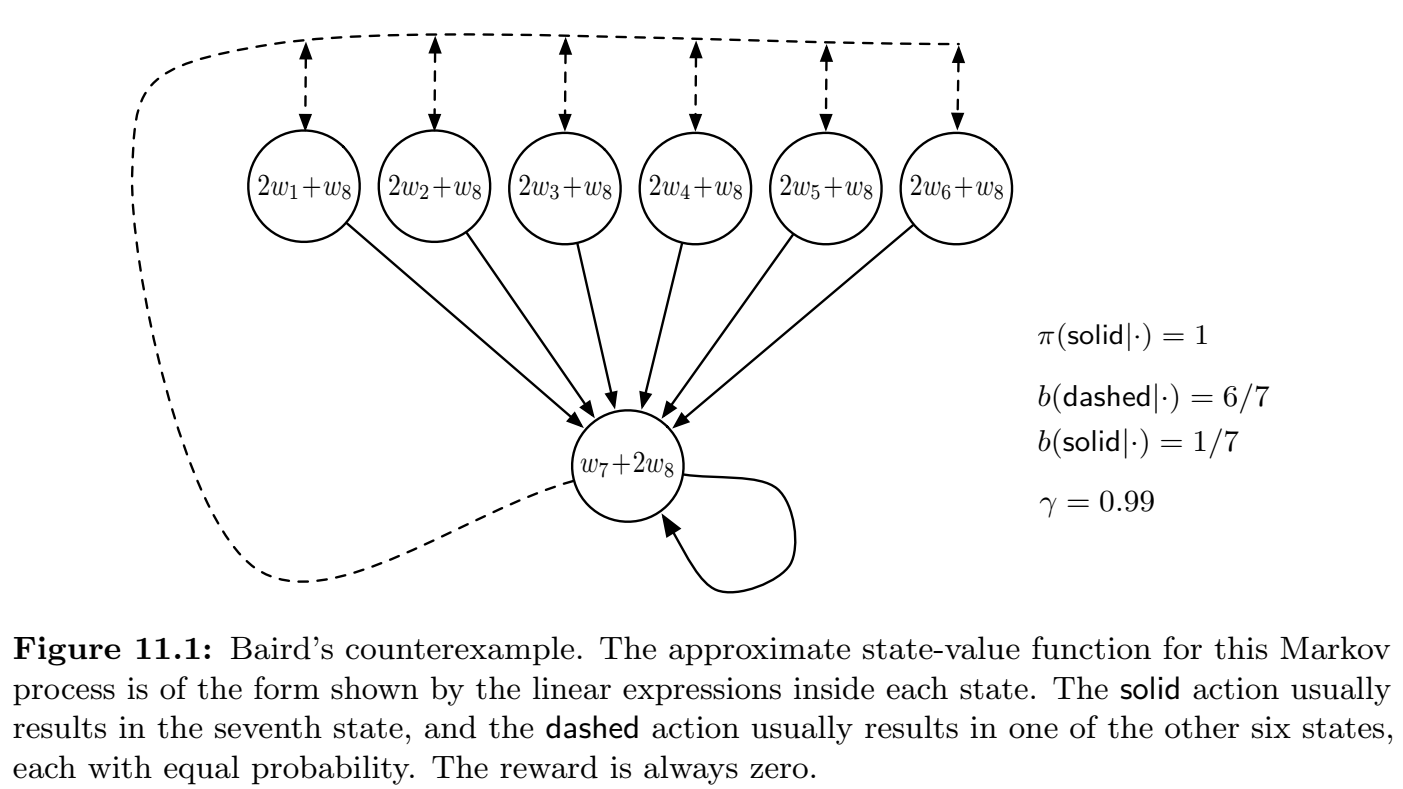

# Packages and helper functions

In [269]:
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from IPython.display import Markdown
import json
import numpy as np

# def save_dictionary_to_file(dictionary, file_path):
#     with open(file_path, 'w') as file:
#         json.dump(dictionary, file, default=convert_to_builtin_type)

# def load_dictionary_from_file(file_path):
#     with open(file_path, 'r') as file:
#         dictionary = json.load(file)
#     return dictionary

import pickle

def save_dictionary_to_file(dictionary, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(dictionary, file)

def load_dictionary_from_file(file_path):
    with open(file_path, 'rb') as file:
        dictionary = pickle.load(file)
    return dictionary


def convert_to_builtin_type(obj):
    if isinstance(obj, (np.ndarray,)):
        return obj.tolist()  # Convert NumPy arrays to lists for serialization
    if isinstance(obj, (int, float)):
        return str(obj)  # Convert numeric values to strings for serialization
    raise TypeError("Object of type '%s' is not JSON serializable" % type(obj).__name__)


def V(i, X, w):
    return np.dot(X[i, :],  w)

enum             = lambda x: enumerate(x)
init_matrix      = lambda sz: np.linalg.init_matrix(sz)
copyd            = lambda x: copy.deepcopy(x)

def normal_dist(x , mean , sd):
    prob_density = (np.pi*sd) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

def error_custom(msg):
    raise Exception(msg)

class ParsUpdate(dict):
    def __init__(self, dictionary):
        super().__init__(dictionary)

    def update(self, update_dict, copy_from_sim='default'):
        idx_copy = str(copy_from_sim)
        iSM = str(update_dict['sim'])
        if not idx_copy in self.keys():
            error_message = '"'+ idx_copy + '" must be a key of the class object!'
            raise Exception(error_message)

        self[iSM] = copyd(self[idx_copy])
        self[iSM] |= update_dict
        

def update_dict(dict_defeault, update_dict):
    dict = copyd(dict_defeault)
    dict |= update_dict

    return dict


# Tunable Parameters

In [96]:
PARS_default = {
             'sim': 1,
    'N_iterations': 19000,
           'gamma': 0.99,
           'alpha': 0.02,
               'K': 12,
              'w0': np.random.randint(1,10, 8)/1 - 5,
               'b': np.array([1/7, 6/7]),
              'pi': np.array([1,   0]),
              'p8': 1,
            'plot': {'plot_1_1_line_in_target_approx_plot': True},
              '⚙': {
                  'sim': {
                        'set_NaN_for_target_and_approx_when_no_update': True}}
    }
p8 = PARS_default['p8']
PARS_default['X'] = np.array([
    [2, 0, 0, 0, 0, 0, 0, p8],
    [0, 2, 0, 0, 0, 0, 0, p8],
    [0, 0, 2, 0, 0, 0, 0, p8],
    [0, 0, 0, 2, 0, 0, 0, p8],
    [0, 0, 0, 0, 2, 0, 0, p8],
    [0, 0, 0, 0, 0, 2, 0, p8],
    [0, 0, 0, 0, 0, 0, 1, 2]
])
update_sim_dict          = lambda D: update_dict(PARS_default, D)

# Functions

## Run&Print MDP

In [121]:
def run_MDP(PARS):

    # Gather parameters
    N_iterations = PARS['N_iterations']
    n            = 7
    m            = 8
    gamma        = PARS['gamma']
    alpha        = PARS['alpha']
    r            = 0
    K            = PARS['K']    # frequency of update of parameter vector w_m
    w0           = PARS['w0']
    X            = PARS['X']
    b            = PARS['b']    # behavior policy
    pi           = PARS['pi']   # target   policy

    # \=================================================

    get_random_state = lambda: np.random.randint(0, n, 1)[0]

    i_0 = get_random_state()
    w   = np.linalg.init_matrix([m, N_iterations+1])
    w_m = np.linalg.init_matrix([m, N_iterations+1])

    w[:, 0]     = w0
    w_m[:, 0]   = w0

    N_actions = len(b)

    if np.sum(b) != 1:
        b[-1] = 1-np.sum(b[:-1])

    target = init_matrix([N_iterations])
    approx = init_matrix([N_iterations])
    delta = init_matrix([N_iterations])

    target_i = target[0]
    approx_i = approx[0]
    z = 0
    for t in range(N_iterations):

        # choose index for state
        i1 = get_random_state()
        rho = 0
        # \==================================================
        p_action = random.uniform(0, 1)

        # Get action
        for i_b, b_i in enumerate(b):
            if p_action <= b_i:
                break
        rho = pi[i_b]/b[i_b]
        if i_b == 0:
            i1 = n
        else:
            i1 = np.random.randint(0, n, 1)[0]
        # \==================================================
        
        UPDATE_HAS_HAPPENED = rho>0

        if UPDATE_HAS_HAPPENED:
            target_i  = r+gamma*V(i1 - 1, X, w_m[:, t])
            approx_i  = V(i_0 - 1, X, w[:, t])

            if np.isnan(target_i) or np.isnan(approx_i):
                raise Exception("Found NaN values for target/approximation")
            
            delta_i   = target_i - approx_i
            Dw        = X[i_0-1, :] * alpha*rho*delta_i
            w[:, t+1] = w[:, t] + Dw
        else:
            delta_i = target_i - approx_i

            if PARS['⚙']['sim']['set_NaN_for_target_and_approx_when_no_update']:
                target_i = np.nan
                approx_i = np.nan
            w[:, t+1] = w[:, t]

            
        target[t] = target_i
        approx[t] = approx_i
        delta[t] = delta_i


        i_0 = i1

        if UPDATE_HAS_HAPPENED: 
            z+=1
            if z % K == 0:
                w_m[:, t+1]=w[:, t+1]
            else:
                w_m[:, t+1]=w_m[:, t]
        else:
            w_m[:, t+1]=w_m[:, t]

    Dw8 = init_matrix([m, N_iterations+1])
    for i in range(N_iterations+1):
        Dw8[:, i] = w[:, i] - w[m-1, i]


    return w, w_m, Dw8, target, approx, delta


def plot_MDP(w, w_m, Dw8, target, approx, delta, PARS, print_to_file=None):

    n_states     = 7
    X            = PARS['X']
    N_iterations = PARS['N_iterations']
    gamma        = PARS['gamma']

    plt.rcParams.update({'font.size': 22})
    plt.figure(figsize=(20,12))



    # plt.plot([i for i in range(N_iterations)], [V(0, X, w[:, i]) for i in range(N_iterations)])
    # plt.plot([i for i in range(N_iterations)], [gamma*V(0, X, w_m[:, i]) for i in range(N_iterations)])
    # plt.legend(['V(s_1, w)', 'gamma*V(s_1, w_m)'])
    # plt.show()


    target_h = np.array([tar for tar in target if not np.isnan(tar)])
    approx_h = np.array([tar for tar in approx if not np.isnan(tar)])

    # if len(target_h) < len(target): 
    #     print("There's NaN values in the target!")

    plt.plot([i for i in range(N_iterations)], approx)
    plt.plot([i for i in range(N_iterations)], target)
    plt.legend(['approx', 'target'])
    plt.show()


    legs = []
    for s in range(n_states):
        plt.plot([i for i in range(N_iterations)], [V(s, X, w[:, i]) for i in range(N_iterations)])
        legs.append(str(s+1))

    
    plt.legend(legs)
    plt.grid()
    plt.xlabel('update step [-]')
    plt.ylabel('V [-]')
    plt.show()


    # plt.plot([i for i in range(N_iterations)], Dw8[1, :-1])
    # plt.grid()
    # plt.show()

    legs = []
    for k in range(8): 
        plt.plot([i for i in range(N_iterations)], w[k, :-1])
        legs.append(str(k+1))
    
    plt.legend(legs)
    plt.grid()
    plt.xlabel('update step [-]')
    plt.ylabel('w [-]')
    plt.show()


    plt.plot(target, approx, '.')

    if PARS['plot']['plot_1_1_line_in_target_approx_plot']:
    
        if np.max(np.abs(target_h))>np.max(np.abs(approx_h)):
            mab1 = np.max(np.abs(target_h))
            idx1 = [i for i, p in enum(target_h) if np.abs(p)==mab1]
            yPts = [0, target_h[idx1[0]]]

        else:
            mab1 = np.max(np.abs(approx_h))
            idx1 = [i for i, p in enum(approx_h) if np.abs(p)==mab1]
            yPts = [0, approx_h[idx1[0]]]

        plt.plot(yPts, yPts)
        


    # PARS['plot']['plot_']

    plt.grid()
    plt.xlabel('target [-]')
    plt.ylabel('approximation [-]')

    plt.show()


    plt.plot([i for i in range(N_iterations)], delta)
    plt.grid()
    plt.xlabel('update step [-]')
    plt.ylabel('$\delta$ [-]')

    plt.show()


    plt.plot([i for i in range(N_iterations)], approx)
    plt.grid()    
    plt.xlabel('update step [-]')
    plt.ylabel('approximation [-]')

    plt.show()


    if not print_to_file is None:
        print("d")



    

## Print-Table

In [236]:
import numpy as np

def print_table(data, transpose=False, sort_key=None):
    if len(data) == 0:
        print("No data to display.")
        return

    # Extract the keys from the first dictionary
    headers = list(data['1'].keys())

    data_1 = []

    for h in data.keys():
        data_1.append(data[h])

    if transpose:
        # Transpose the data
        data_1 = [{key: value for key, value in zip(data.keys(), values)} for values in zip(*[d.values() for d in data_1])]

    if sort_key:
        data_1 = sorted(data_1, key=lambda x: x.get(sort_key))

    # Determine the dimensions of the table
    num_rows = len(data_1)
    num_cols = len(headers)

    if not transpose:
        # Calculate the maximum width of each column
        col_widths = {}
        for header in headers:
            col_widths[header] = max(len(str(header)), max(len(str(d.get(header, ""))) for d in data_1))

        # Print the headers
        print("| " + " | ".join(f"{header:^{col_widths[header]}}" for header in headers) + " |")
        print("|" + "|".join("-" * (col_widths[header] + 2) for header in headers) + "|")

        # Print the data
        for d in data_1:
            for header in headers:
                value = d.get(header, '')
                if isinstance(value, np.ndarray):
                    value_str = str(value).replace('\n', '')
                    print(f"| {value_str:^{col_widths[header]}} ", end="")
                elif isinstance(value, int):
                    print(f"| {str(value):>{col_widths[header]}} ", end="")
                else:
                    print(f"| {str(value):<{col_widths[header]}} ", end="")
            print("|")

    else:
        # Transpose the table
        transposed_data = [{headers[j]: data_1[i].get(headers[j], '') for j in range(num_cols)} for i in range(num_rows)]

        if sort_key:
            transposed_data = sorted(transposed_data, key=lambda x: x.get(sort_key))

        # Calculate the maximum width of each column
        col_widths = {}
        for header in headers:
            col_widths[header] = max(len(str(header)), max(len(str(d.get(header, ""))) for d in transposed_data))

        # Print the headers
        for header in headers:
            print(f"{header:^{col_widths[header]}} ", end="")
        print()

        # Print the data
        for d in transposed_data:
            for header in headers:
                value = d.get(header, '')
                if isinstance(value, np.ndarray):
                    value_str = str(value).replace('\n', '')
                    print(f"{value_str:^{col_widths[header]}} ", end="")
                elif isinstance(value, int):
                    print(f"{str(value):>{col_widths[header]}} ", end="")
                else:
                    print(f"{str(value):<{col_widths[header]}} ", end="")
            print()


# Parameter Studies

## Initialize

In [15]:
PARS = ParsUpdate(dict())
SIGS = dict()
PERFORMANCE_INDEX = ParsUpdate(dict())

PARS['default'] = PARS_default

## Performance Indexes

- Convergence Rate
    1. Low
    2. Medium
    3. High
    4.  Does not converge
- Correlation between update and approximation
    1. Starts high, ends 0
    2. 0
    3. High


In [16]:
IDX__CONVERGENCE_RATE__LOW                            = 'Low'
IDX__CONVERGENCE_RATE__EXTREMELY_LOW                  = 'Extremely Low'
IDX__CONVERGENCE_RATE__MEDIUM                         = 'Medium'
IDX__CONVERGENCE_RATE__HIGH                           = 'High'
IDX__CONVERGENCE_RATE__DOES_NOT_CONVERGE              = 'No Convergence'

IDX__CORRELATION_UPDATE_APPROX__STARTS_HIGH_ENDS_ZERO = 'starts high, ends at 0'
IDX__CORRELATION_UPDATE_APPROX__ZERO                  = '0'
IDX__CORRELATION_UPDATE_APPROX__HIGH                  = 'High'
IDX__CORRELATION_UPDATE_APPROX__LOW                   = 'Low'

IDX__APPROXIMATION_ACCURACY__LOW                      = 'Low'
IDX__APPROXIMATION_ACCURACY__HIGH                     = 'High'
IDX__APPROXIMATION_ACCURACY__NOT_APPL                 = 'N/A'


PERFORMANCE_INDEX_DEFAULT = {
                                             'sim': 1,
                                'convergence_rate': IDX__CONVERGENCE_RATE__DOES_NOT_CONVERGE,
    'correlation between update and approximation': IDX__CORRELATION_UPDATE_APPROX__STARTS_HIGH_ENDS_ZERO,
                          'approximation accuracy': IDX__APPROXIMATION_ACCURACY__LOW
    }

PERFORMANCE_INDEX['default'] = PERFORMANCE_INDEX_DEFAULT
update_performance_index = lambda D: update_dict(PERFORMANCE_INDEX_DEFAULT, D)

## 📈 Compare sims

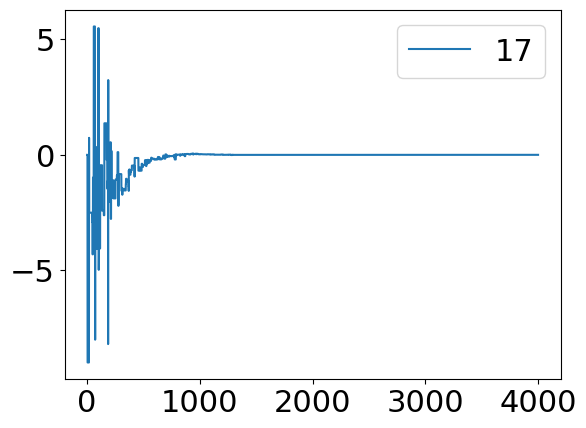

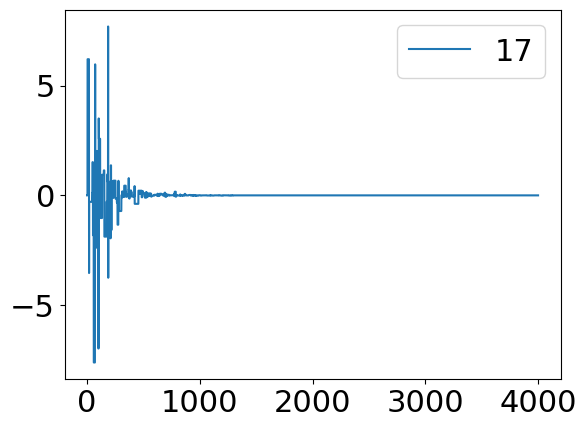

In [239]:
sims_compare = [
    17
    ]

sigs_to_plot = [4, 5]


if not 'SIGS' in locals():
    SIGS = load_dictionary_from_file('SIGNALS.pkl')

for sig_plot in sigs_to_plot: 
    for sim in sims_compare:
        plt.plot([i for i in range(len(SIGS[str(sim)][sig_plot]))], SIGS[str(sim)][sig_plot])
    plt.legend([str(s) for s in sims_compare])
    plt.show()
    

## Iter sim

In [271]:
sim_indexes = list(PARS.keys())
sim_indexes = [int(idx) for idx in sim_indexes if idx.isdigit()]
# for idx in sim_indexes:
sim_index = max(sim_indexes)+1


PARS.update({
             'sim': sim_index,
           'alpha': 0.06
}, copy_from_sim=23)

iSM = str(sim_index) 
SIGS[iSM] = run_MDP(PARS[iSM])

print("sim_index = " + str(sim_index))

w, w_m, Dw8, target, approx, delta = SIGS[iSM]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[iSM])

TypeError: ParsUpdate.update() got an unexpected keyword argument 'copy_from_sim'

In [ ]:
iSM = '23'
w, w_m, Dw8, target, approx, delta = SIGS[iSM]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[iSM])

### 📝

In [213]:
save_dictionary_to_file(SIGS, 'SIGNALS.pkl')
loaded_dict = load_dictionary_from_file('SIGNALS.pkl')

In [183]:
w, w_m, Dw8, target, approx, delta = loaded_dict['1']
w.shape

(8, 1001)

In [266]:
comment = ''

PERFORMANCE_INDEX.update({
                                             'sim': 23,
                                'convergence_rate': IDX__CONVERGENCE_RATE__HIGH,
    'correlation between update and approximation': IDX__CORRELATION_UPDATE_APPROX__ZERO,
                          'approximation accuracy': IDX__APPROXIMATION_ACCURACY__HIGH,
                                         'comment': comment
})

In [267]:
TABLE__PERFORMANCE = print_table(PERFORMANCE_INDEX, sort_key='sim')
print('')
TABLE__PARAMETERS = print_table(PARS, sort_key='sim')

# display(Markdown(TABLE__PERFORMANCE))
# display(Markdown(TABLE__PARAMETERS))
TABLE__PERFORMANCE

| sim | convergence_rate | correlation between update and approximation | approximation accuracy |                           comment                            |
|-----|------------------|----------------------------------------------|------------------------|--------------------------------------------------------------|
|   1 | No Convergence   | starts high, ends at 0                       | Low                    |                                                              |
|   1 | Low              | 0                                            | High                   | Small convergence due to oscillations around the equilibrium |
|  14 | Low              | High                                         | High                   | Very slow convergence. Maybe reducing gamma will help        |
|  15 | High             | High                                         | High                   | Convergence improved! Can we further improve it?             |
|  16 | High             | H

In [ ]:
from IPython.display import Markdown

# Define the table in Markdown format
table = """
| sim | N_iterations | gamma | alpha  | K  |                w0                 |            b            |  pi   | p8 |                     plot                      |                                                                                               X                                                                                               |                                ⚙                                 |
|-----|--------------|-------|--------|----|-----------------------------------|-------------------------|-------|----|-----------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------|
|   1 |        19000 | 0.99  | 0.02   | 12 | [ 3.  1.  3. -4.  0. -4. -2. -1.] | [0.14285714 0.85714286] | [1 0] |  1 | {'plot_1_1_line_in_target_approx_plot': True} |                                [[2 0 0 0 0 0 0 1] [0 2 0 0 0 0 0 1] [0 0 2 0 0 0 0 1] [0 0 0 2 0 0 0 1] [0 0 0 0 2 0 0 1] [0 0 0 0 0 2 0 1] [0 0 0 0 0 0 1 2]]                                |                                                                  |
|   1 |         1000 | 0.7   | 0.04   |  1 | [ 3.  1.  3. -4.  0. -4. -2. -1.] | [0.14285714 0.85714286] | [1 0] |  1 | {'plot_1_1_line_in_target_approx_plot': True} |                                [[2 0 0 0 0 0 0 1] [0 2 0 0 0 0 0 1] [0 0 2 0 0 0 0 1] [0 0 0 2 0 0 0 1] [0 0 0 0 2 0 0 1] [0 0 0 0 0 2 0 1] [0 0 0 0 0 0 1 2]]                                | {'sim': {'set_NaN_for_target_and_approx_when_no_update': False}} |
|   2 |         1000 | 0.99  | 0.02   |  1 | [ 1.  4.  0.  3.  0. -4.  1.  4.] | [0.14285714 0.85714286] | [1 0] |  1 | {'plot_1_1_line_in_target_approx_plot': True} |                                [[2 0 0 0 0 0 0 1] [0 2 0 0 0 0 0 1] [0 0 2 0 0 0 0 1] [0 0 0 2 0 0 0 1] [0 0 0 0 2 0 0 1] [0 0 0 0 0 2 0 1] [0 0 0 0 0 0 1 2]]                                |                                                                  |
|   3 |         1000 | 0.99  | 0.02   |  1 | [ 3.  1.  3. -4.  0. -4. -2. -1.] | [0.14285714 0.85714286] | [1 0] | -1 | {'plot_1_1_line_in_target_approx_plot': True} |    [[ 2  0  0  0  0  0  0 -1] [ 0  2  0  0  0  0  0 -1] [ 0  0  2  0  0  0  0 -1] [ 0  0  0  2  0  0  0 -1] [ 0  0  0  0  2  0  0 -1] [ 0  0  0  0  0  2  0 -1] [ 0  0  0  0  0  0  1  2]]    |                                                                  |
|   5 |        19000 | 0.99  | 0.02   |  6 | [ 3.  1.  3. -4.  0. -4. -2. -1.] | [0.14285714 0.85714286] | [1 0] |  1 | {'plot_1_1_line_in_target_approx_plot': True} |                                [[2 0 0 0 0 0 0 1] [0 2 0 0 0 0 0 1] [0 0 2 0 0 0 0 1] [0 0 0 2 0 0 0 1] [0 0 0 0 2 0 0 1] [0 0 0 0 0 2 0 1] [0 0 0 0 0 0 1 2]]                                |                                                                  |
|   7 |        10000 | 0.99  | 0.002  |  1 | [ 3.  1.  3. -4.  0. -4. -2. -1.] | [0.14285714 0.85714286] | [1 0] | -1 | {'plot_1_1_line_in_target_approx_plot': True} |    [[ 2  0  0  0  0  0  0 -1] [ 0  2  0  0  0  0  0 -1] [ 0  0  2  0  0  0  0 -1] [ 0  0  0  2  0  0  0 -1] [ 0  0  0  0  2  0  0 -1] [ 0  0  0  0  0  2  0 -1] [ 0  0  0  0  0  0  1  2]]    |                                                                  |
|  12 |        10000 | 0.99  | 0.002  |  1 | [ 3.  1.  3. -4.  0. -4. -2. -1.] |        [0.5 0.5]        | [1 0] | -1 | {'plot_1_1_line_in_target_approx_plot': True} |    [[ 2  0  0  0  0  0  0 -1] [ 0  2  0  0  0  0  0 -1] [ 0  0  2  0  0  0  0 -1] [ 0  0  0  2  0  0  0 -1] [ 0  0  0  0  2  0  0 -1] [ 0  0  0  0  0  2  0 -1] [ 0  0  0  0  0  0  1  2]]    |                                                                  |
|  13 |         3500 | 0.99  | 0.0002 |  1 | [ 3.  1.  3. -4.  0. -4. -2. -1.] | [0.14285714 0.85714286] | [1 0] |  1 | {'plot_1_1_line_in_target_approx_plot': True} |                                [[2 0 0 0 0 0 0 1] [0 2 0 0 0 0 0 1] [0 0 2 0 0 0 0 1] [0 0 0 2 0 0 0 1] [0 0 0 0 2 0 0 1] [0 0 0 0 0 2 0 1] [0 0 0 0 0 0 1 2]]                                |                                                                  |
|  14 |         1000 | 0.98  | 0.04   |  6 | [ 3.  1.  3. -4.  0. -4. -2. -1.] | [0.14285714 0.85714286] | [1 0] |  1 | {'plot_1_1_line_in_target_approx_plot': True} |                                [[2 0 0 0 0 0 0 1] [0 2 0 0 0 0 0 1] [0 0 2 0 0 0 0 1] [0 0 0 2 0 0 0 1] [0 0 0 0 2 0 0 1] [0 0 0 0 0 2 0 1] [0 0 0 0 0 0 1 2]]                                | {'sim': {'set_NaN_for_target_and_approx_when_no_update': False}} |
|  15 |         1000 | 0.8   | 0.04   |  6 | [ 3.  1.  3. -4.  0. -4. -2. -1.] | [0.14285714 0.85714286] | [1 0] |  1 | {'plot_1_1_line_in_target_approx_plot': True} |                                [[2 0 0 0 0 0 0 1] [0 2 0 0 0 0 0 1] [0 0 2 0 0 0 0 1] [0 0 0 2 0 0 0 1] [0 0 0 0 2 0 0 1] [0 0 0 0 0 2 0 1] [0 0 0 0 0 0 1 2]]                                | {'sim': {'set_NaN_for_target_and_approx_when_no_update': False}} |
|  16 |         1000 | 0.7   | 0.04   |  6 | [ 3.  1.  3. -4.  0. -4. -2. -1.] | [0.14285714 0.85714286] | [1 0] |  1 | {'plot_1_1_line_in_target_approx_plot': True} |                                [[2 0 0 0 0 0 0 1] [0 2 0 0 0 0 0 1] [0 0 2 0 0 0 0 1] [0 0 0 2 0 0 0 1] [0 0 0 0 2 0 0 1] [0 0 0 0 0 2 0 1] [0 0 0 0 0 0 1 2]]                                | {'sim': {'set_NaN_for_target_and_approx_when_no_update': False}} |
|  17 |         4000 | 0.7   | 0.04   |  6 | [ 3.  1.  3. -4.  0. -4. -2. -1.] | [0.14285714 0.85714286] | [1 0] |  1 | {'plot_1_1_line_in_target_approx_plot': True} |                                [[2 0 0 0 0 0 0 1] [0 2 0 0 0 0 0 1] [0 0 2 0 0 0 0 1] [0 0 0 2 0 0 0 1] [0 0 0 0 2 0 0 1] [0 0 0 0 0 2 0 1] [0 0 0 0 0 0 1 2]]                                | {'sim': {'set_NaN_for_target_and_approx_when_no_update': False}} |
|  18 |         4000 | 0.98  | 0.04   |  6 | [ 3.  1.  3. -4.  0. -4. -2. -1.] | [0.14285714 0.85714286] | [1 0] |  1 | {'plot_1_1_line_in_target_approx_plot': True} |                                [[2 0 0 0 0 0 0 1] [0 2 0 0 0 0 0 1] [0 0 2 0 0 0 0 1] [0 0 0 2 0 0 0 1] [0 0 0 0 2 0 0 1] [0 0 0 0 0 2 0 1] [0 0 0 0 0 0 1 2]]                                | {'sim': {'set_NaN_for_target_and_approx_when_no_update': False}} |
|  19 |         4000 | 0.98  | 0.04   |  1 | [ 3.  1.  3. -4.  0. -4. -2. -1.] | [0.14285714 0.85714286] | [1 0] |  1 | {'plot_1_1_line_in_target_approx_plot': True} |                                [[2 0 0 0 0 0 0 1] [0 2 0 0 0 0 0 1] [0 0 2 0 0 0 0 1] [0 0 0 2 0 0 0 1] [0 0 0 0 2 0 0 1] [0 0 0 0 0 2 0 1] [0 0 0 0 0 0 1 2]]                                | {'sim': {'set_NaN_for_target_and_approx_when_no_update': False}} |
|  20 |         4000 | 0.98  | 0.04   |  2 | [ 3.  1.  3. -4.  0. -4. -2. -1.] | [0.14285714 0.85714286] | [1 0] |  1 | {'plot_1_1_line_in_target_approx_plot': True} |                                [[2 0 0 0 0 0 0 1] [0 2 0 0 0 0 0 1] [0 0 2 0 0 0 0 1] [0 0 0 2 0 0 0 1] [0 0 0 0 2 0 0 1] [0 0 0 0 0 2 0 1] [0 0 0 0 0 0 1 2]]                                | {'sim': {'set_NaN_for_target_and_approx_when_no_update': False}} |
|  21 |         4000 | 0.98  | 0.04   |  3 | [ 3.  1.  3. -4.  0. -4. -2. -1.] | [0.14285714 0.85714286] | [1 0] |  1 | {'plot_1_1_line_in_target_approx_plot': True} |                                [[2 0 0 0 0 0 0 1] [0 2 0 0 0 0 0 1] [0 0 2 0 0 0 0 1] [0 0 0 2 0 0 0 1] [0 0 0 0 2 0 0 1] [0 0 0 0 0 2 0 1] [0 0 0 0 0 0 1 2]]                                | {'sim': {'set_NaN_for_target_and_approx_when_no_update': False}} |
|  22 |         1000 | 0.6   | 0.04   |  6 | [ 3.  1.  3. -4.  0. -4. -2. -1.] | [0.14285714 0.85714286] | [1 0] |  1 | {'plot_1_1_line_in_target_approx_plot': True} |                                [[2 0 0 0 0 0 0 1] [0 2 0 0 0 0 0 1] [0 0 2 0 0 0 0 1] [0 0 0 2 0 0 0 1] [0 0 0 0 2 0 0 1] [0 0 0 0 0 2 0 1] [0 0 0 0 0 0 1 2]]                                | {'sim': {'set_NaN_for_target_and_approx_when_no_update': False}} |
|  23 |         1000 | 0.6   | 0.04   |  1 | [ 3.  1.  3. -4.  0. -4. -2. -1.] | [0.14285714 0.85714286] | [1 0] |  1 | {'plot_1_1_line_in_target_approx_plot': True} |                                [[2 0 0 0 0 0 0 1] [0 2 0 0 0 0 0 1] [0 0 2 0 0 0 0 1] [0 0 0 2 0 0 0 1] [0 0 0 0 2 0 0 1] [0 0 0 0 0 2 0 1] [0 0 0 0 0 0 1 2]]                                | {'sim': {'set_NaN_for_target_and_approx_when_no_update': False}} |
|  24 |         1000 | 0.45  | 0.04   |  1 | [ 3.  1.  3. -4.  0. -4. -2. -1.] | [0.14285714 0.85714286] | [1 0] |  1 | {'plot_1_1_line_in_target_approx_plot': True} |                                [[2 0 0 0 0 0 0 1] [0 2 0 0 0 0 0 1] [0 0 2 0 0 0 0 1] [0 0 0 2 0 0 0 1] [0 0 0 0 2 0 0 1] [0 0 0 0 0 2 0 1] [0 0 0 0 0 0 1 2]]                                | {'sim': {'set_NaN_for_target_and_approx_when_no_update': False}} |
|  25 |         1000 | 0.45  | 0.2    |  1 | [ 3.  1.  3. -4.  0. -4. -2. -1.] | [0.14285714 0.85714286] | [1 0] |  1 | {'plot_1_1_line_in_target_approx_plot': True} |                                [[2 0 0 0 0 0 0 1] [0 2 0 0 0 0 0 1] [0 0 2 0 0 0 0 1] [0 0 0 2 0 0 0 1] [0 0 0 0 2 0 0 1] [0 0 0 0 0 2 0 1] [0 0 0 0 0 0 1 2]]                                | {'sim': {'set_NaN_for_target_and_approx_when_no_update': False}} |
|  26 |         1000 | 0.45  | 0.1    |  1 | [ 3.  1.  3. -4.  0. -4. -2. -1.] | [0.14285714 0.85714286] | [1 0] |  1 | {'plot_1_1_line_in_target_approx_plot': True} |                                [[2 0 0 0 0 0 0 1] [0 2 0 0 0 0 0 1] [0 0 2 0 0 0 0 1] [0 0 0 2 0 0 0 1] [0 0 0 0 2 0 0 1] [0 0 0 0 0 2 0 1] [0 0 0 0 0 0 1 2]]                                | {'sim': {'set_NaN_for_target_and_approx_when_no_update': False}} |
|  27 |         1000 | 0.45  | 0.06   |  1 | [ 3.  1.  3. -4.  0. -4. -2. -1.] | [0.14285714 0.85714286] | [1 0] |  1 | {'plot_1_1_line_in_target_approx_plot': True} |                                [[2 0 0 0 0 0 0 1] [0 2 0 0 0 0 0 1] [0 0 2 0 0 0 0 1] [0 0 0 2 0 0 0 1] [0 0 0 0 2 0 0 1] [0 0 0 0 0 2 0 1] [0 0 0 0 0 0 1 2]]                                | {'sim': {'set_NaN_for_target_and_approx_when_no_update': False}} |
"""

# Display the table in Markdown mode
display(Markdown(table))


## 1

In [225]:
sim_index = 1

iSM = str(sim_index) 

PARS.update({
             'sim': sim_index,
    'N_iterations': 1000,
               'K': 1,
           'alpha': 0.04,
           'gamma': 0.7,
               '⚙': {
                   'sim': {
                       'set_NaN_for_target_and_approx_when_no_update': False}}
})


SIGS[iSM] = run_MDP(PARS[iSM])

### Plots

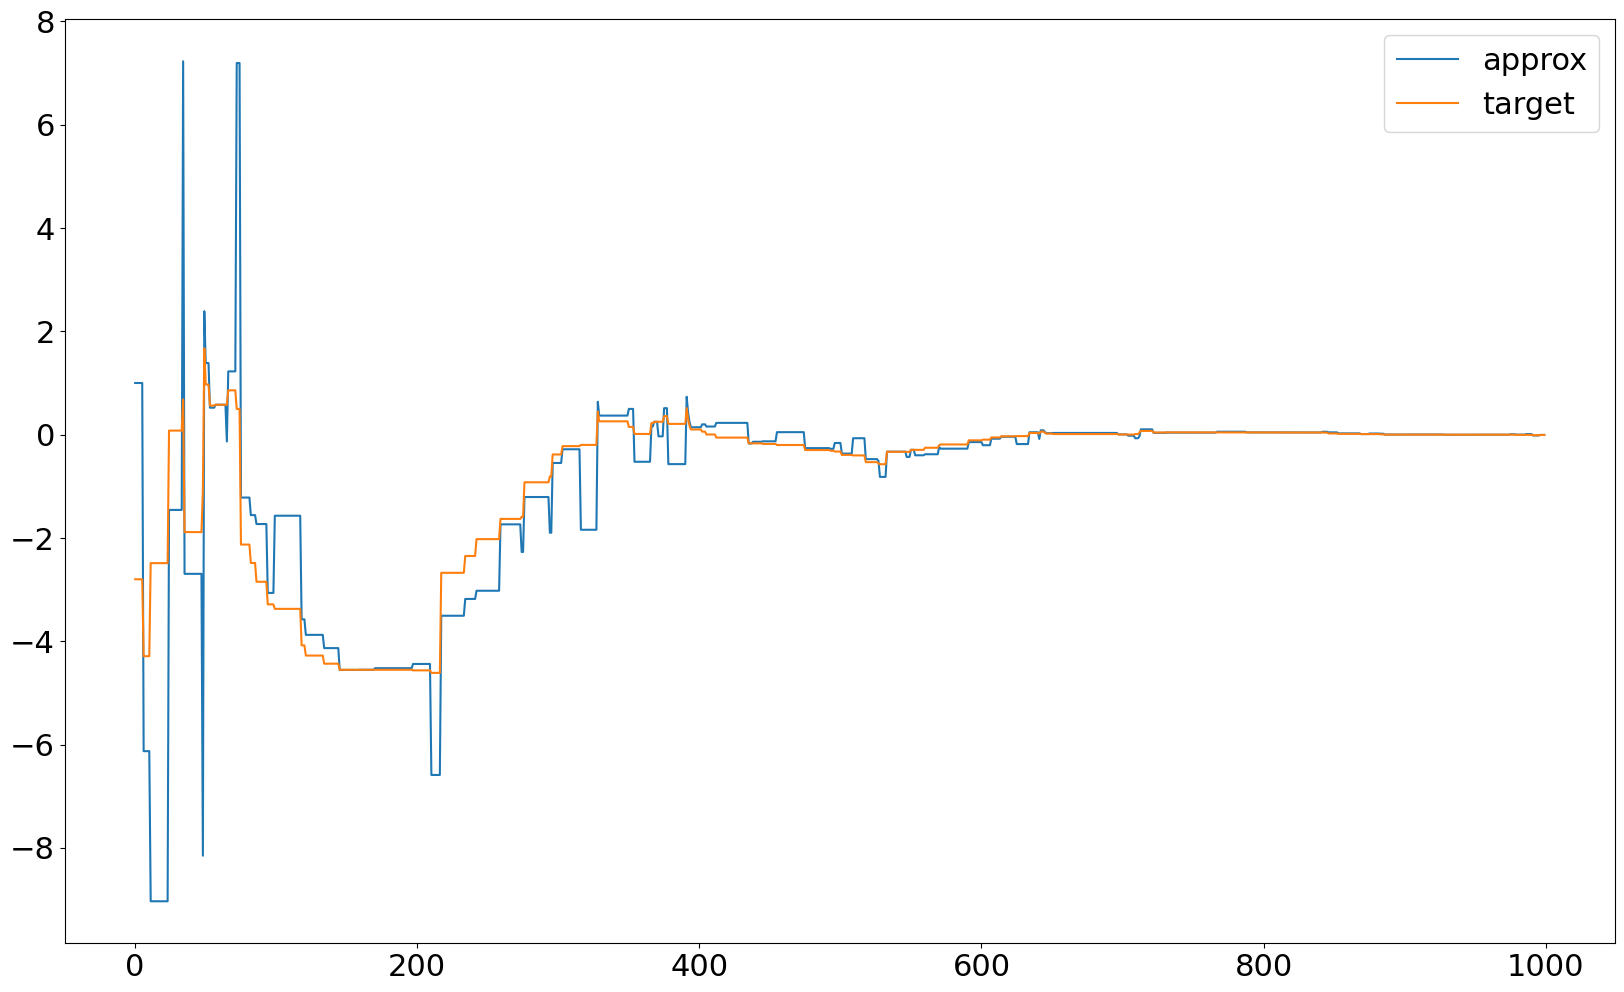

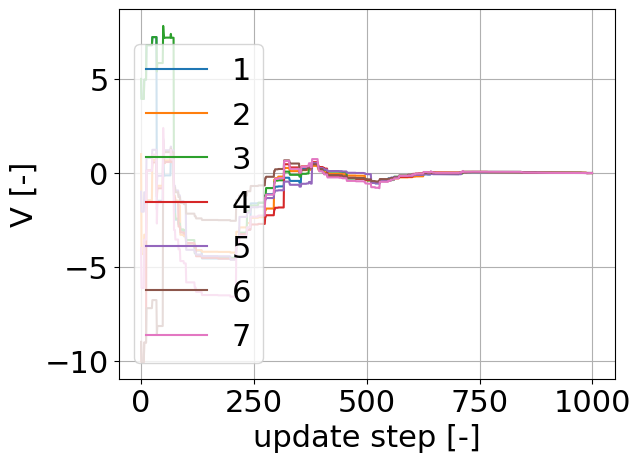

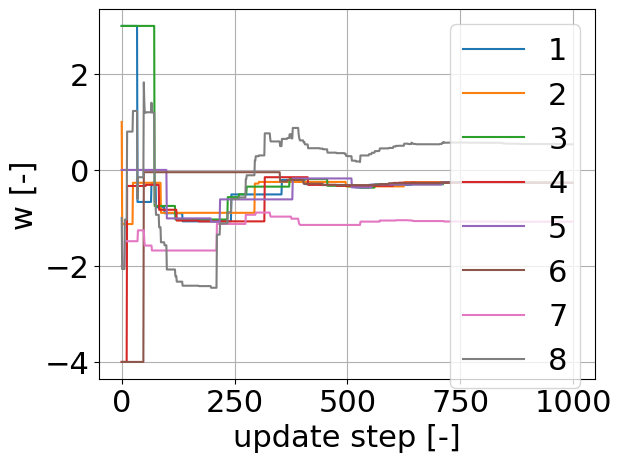

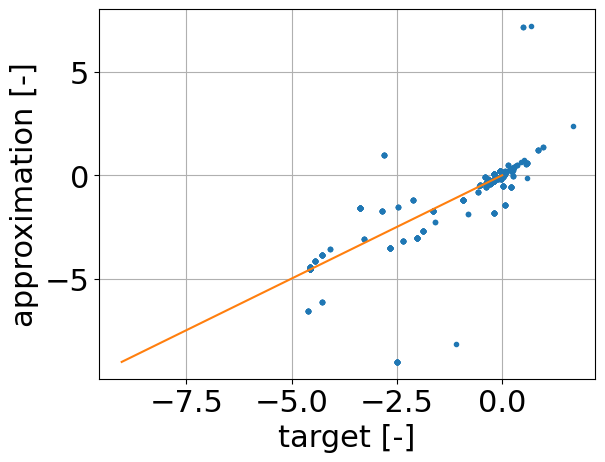

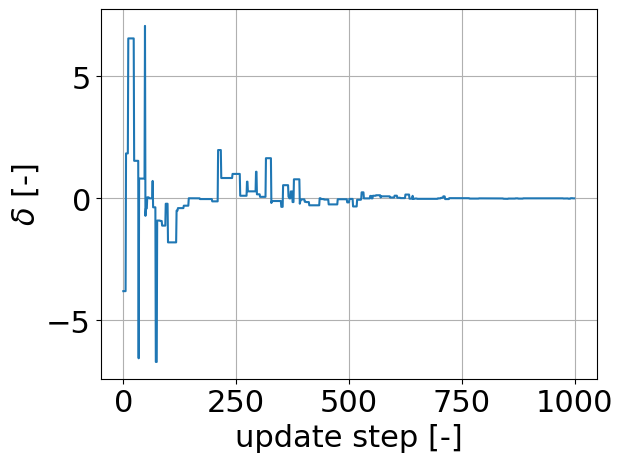

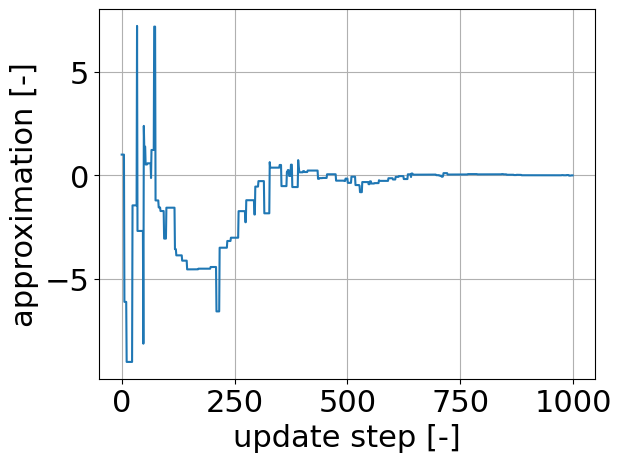

In [226]:
w, w_m, Dw8, target, approx, delta = SIGS[str(sim_index)]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[str(sim_index)])

### 💭

- Slow convergence


In [227]:
PERFORMANCE_INDEX.update({
                                             'sim': 1,
                                'convergence_rate': IDX__CONVERGENCE_RATE__LOW,
    'correlation between update and approximation': IDX__CORRELATION_UPDATE_APPROX__HIGH,
                          'approximation accuracy': IDX__APPROXIMATION_ACCURACY__HIGH
})

In [131]:
PARS['1']

{'sim': 1,
 'N_iterations': 1000,
 'gamma': 0.7,
 'alpha': 0.04,
 'K': 1,
 'w0': array([ 3.,  1.,  3., -4.,  0., -4., -2., -1.]),
 'b': array([0.14285714, 0.85714286]),
 'pi': array([1, 0]),
 'p8': 1,
 'plot': {'plot_1_1_line_in_target_approx_plot': True},
 'X': array([[2, 0, 0, 0, 0, 0, 0, 1],
        [0, 2, 0, 0, 0, 0, 0, 1],
        [0, 0, 2, 0, 0, 0, 0, 1],
        [0, 0, 0, 2, 0, 0, 0, 1],
        [0, 0, 0, 0, 2, 0, 0, 1],
        [0, 0, 0, 0, 0, 2, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 2]]),
 '⚙': {'sim': {'set_NaN_for_target_and_approx_when_no_update': False}}}

In [ ]:
import numpy as np

my_dict = SIGS['1']#{'key1': np.array([1, 2, 3]), 'key2': np.array([4, 5, 6]), 'key3': np.array([7, 8, 9])}
file_path = 'dictionary.txt'

# Save the dictionary to a file
save_dictionary_to_file(my_dict, file_path)

# Load the dictionary from the file
loaded_dict = load_dictionary_from_file(file_path)

# Print the loaded dictionary
loaded_dict

## 2
What happens if we do not use the additional set of parameters?

In [52]:
sim_index = 2
PARS.update({
             'sim': sim_index,
               'K': 1,
              'w0': np.random.randint(1,10, 8)/1 - 5,
    'N_iterations': 1000
})

iSM = str(sim_index)
SIGS[iSM]  = run_MDP(PARS[iSM])

#### Plots

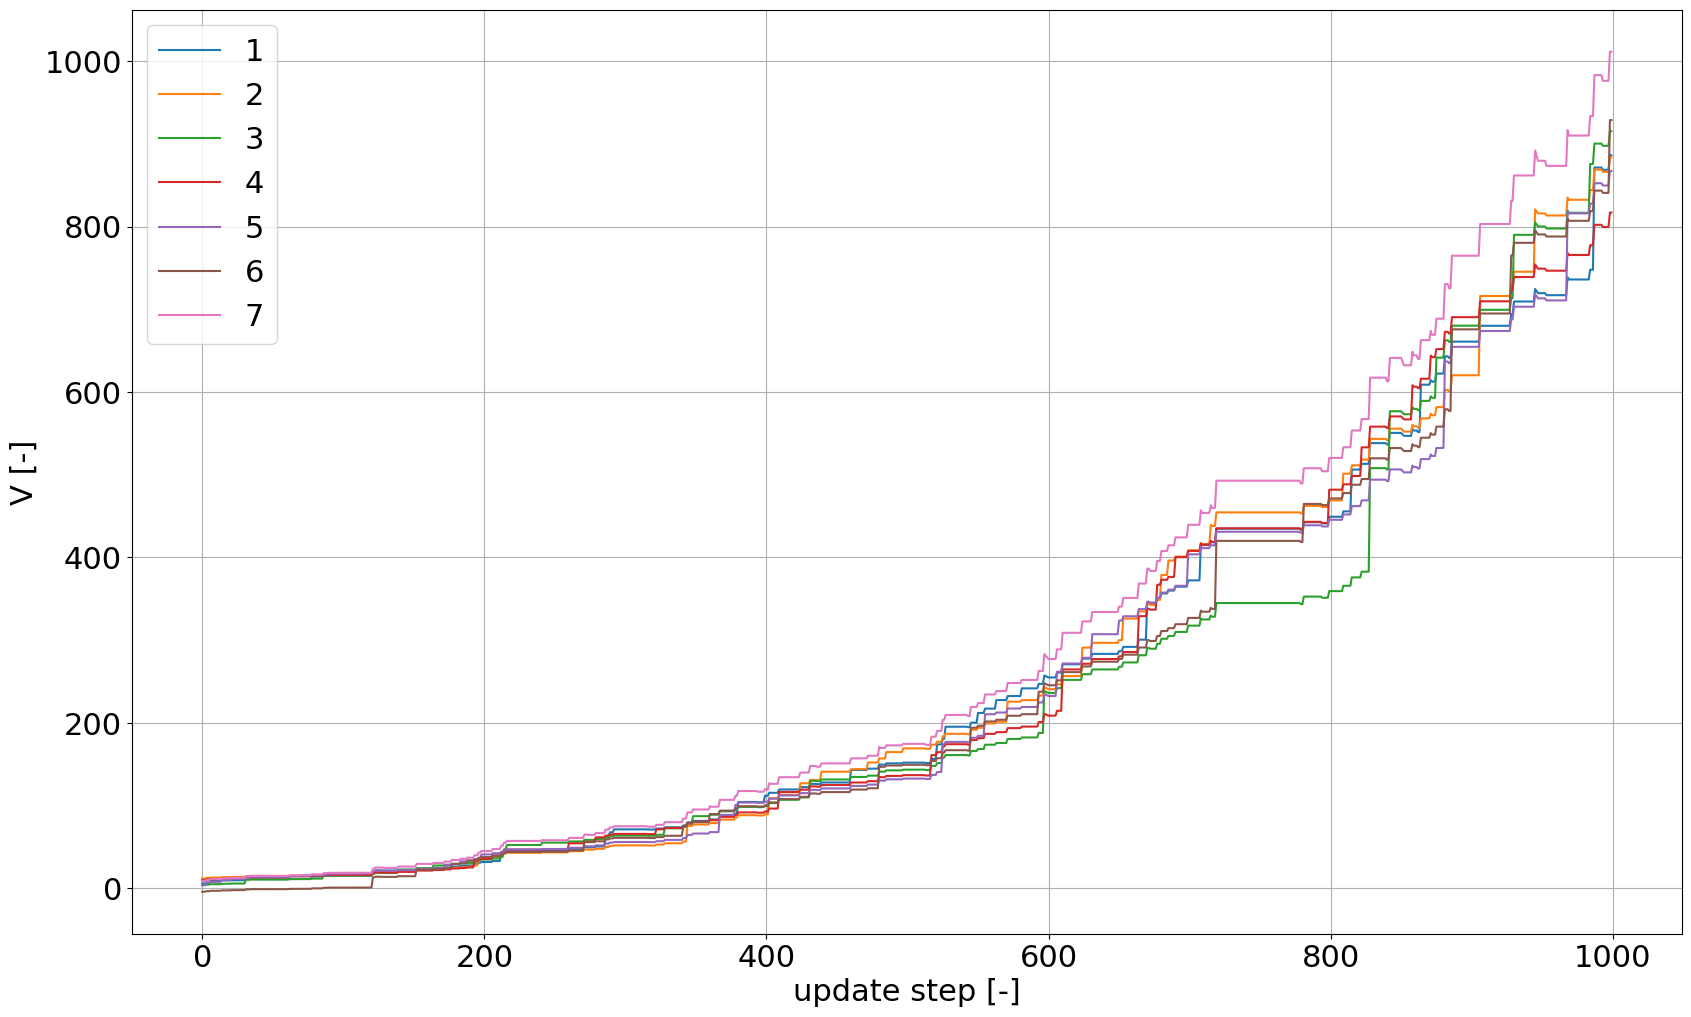

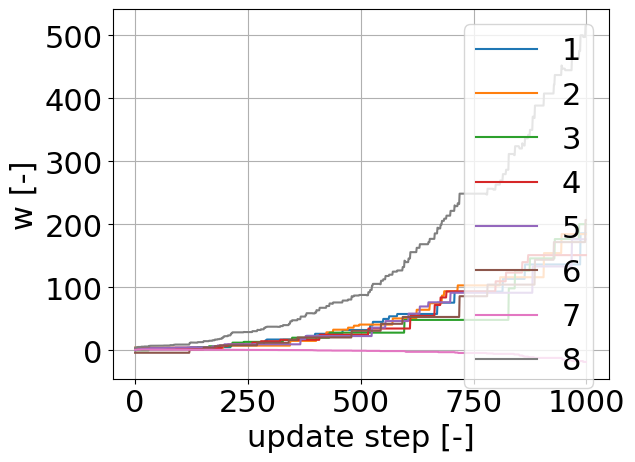

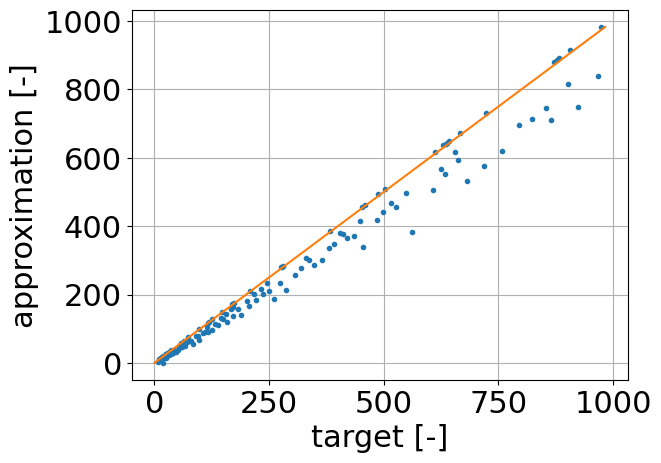

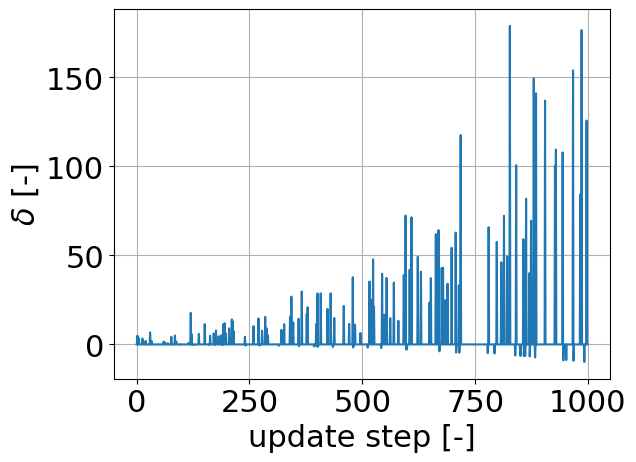

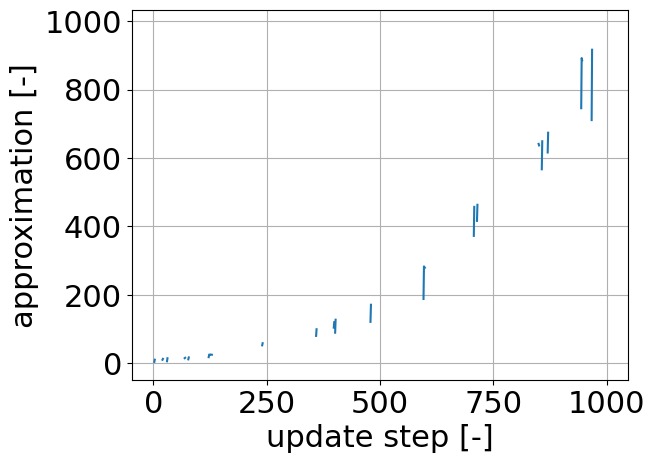

In [53]:
w, w_m, Dw8, target, approx, delta = SIGS[str(sim_index)]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[str(sim_index)])

### Some Analysis

In [52]:
w=w.transpose()

In [53]:
# Some analysis

# w, w_m, Dw8, target, approx, delta

update_index = []
w0 = w[0, :]

for i, wi in enum(w[1:]):
    Dw=wi-w0
    idx1 = [i for i, Dwi in enum(Dw) if Dwi!=0 and i!=7]
    if len(idx1)>0:
        update_index.append([i, idx1[0]])

    w0=wi
    
print('')

#### Tabulate

In [ ]:
# for idx in update_index:

import pandas as pd
from tabulate import tabulate


alpha1=PARS['2']['alpha']*7
X = PARS['2']['X']
results = [
        [
        delta[idx[0]],
        2*alpha1*delta[idx[0]],
        5*alpha1*delta[idx[0]]*(idx[1]==1) + alpha1*delta[idx[0]]*(idx[1]!=1),
        target[idx[0]], 
        approx[idx[0]], 
        idx[1]+1,
        V(1-1, X, w[idx[0], :]),
        V(2-1, X, w[idx[0], :]),
        V(3-1, X, w[idx[0], :]),
        V(4-1, X, w[idx[0], :]),
        V(5-1, X, w[idx[0], :]),
        V(6-1, X, w[idx[0], :]),
        V(7-1, X, w[idx[0], :])
        ] 
        for idx in update_index
    ]

labels = ["Delta", "Increment-7", "Increament-2", "Target", "Approx", "Index",\
                                  "V_1", "V_2", "V_3", "V_4", "V_5", "V_6", "V_7"]

print(tabulate(results, headers=labels))



# assuming `results` is a list of lists or a 2D numpy array

# create a DataFrame from the `results` list
df = pd.DataFrame(results, columns=["Delta", "Increment-7", "Increament-2", "Target", "Approx", "Index", "V_1", "V_2", "V_3", "V_4", "V_5", "V_6", "V_7"])

# write the DataFrame to an Excel file
with pd.ExcelWriter('output.xlsx') as writer:
    df.to_excel(writer, index=False, sheet_name='Sheet1')

# print the tabulated results to the console
print(tabulate(results, headers=labels))



### 💭
Now we can see that:

- Correlation between update and target exists. 
- The distance from the 1:1 line increases, which is expected (see what I wrote in SN). The target is always larger than the approximation, which is expected

Note: depending on the different initial conditions and random selections of actions, the value function estimation can be either positive or negative

In [77]:
PERFORMANCE_INDEX.update({
                                             'sim': 2,
                                'convergence_rate': IDX__CONVERGENCE_RATE__DOES_NOT_CONVERGE,
    'correlation between update and approximation': IDX__CORRELATION_UPDATE_APPROX__HIGH,
                          'approximation accuracy': IDX__APPROXIMATION_ACCURACY__NOT_APPL 
})

NameError: name 'IDX__CONVERGENCE_RATE__DOES_NOT_CONVERGE' is not defined

## 3
We believe that the reason for the instabilities is the choice of including $w_{8}$ inside the value function approximation of every state. If instead we were to not include it, we would have something else.

In [38]:
sim_index = 3

p8_new = -1
PARS.update({
             'sim': sim_index,
               'K': 1,
    'N_iterations': 1000,
              'p8': p8_new,
               'X':np.array([
                    [2, 0, 0, 0, 0, 0, 0, p8_new],
                    [0, 2, 0, 0, 0, 0, 0, p8_new],
                    [0, 0, 2, 0, 0, 0, 0, p8_new],
                    [0, 0, 0, 2, 0, 0, 0, p8_new],
                    [0, 0, 0, 0, 2, 0, 0, p8_new],
                    [0, 0, 0, 0, 0, 2, 0, p8_new],
                    [0, 0, 0, 0, 0, 0, 1, 2]])
})

iSM = str(sim_index)
SIGS[iSM]  = run_MDP(PARS[iSM])

### Plots

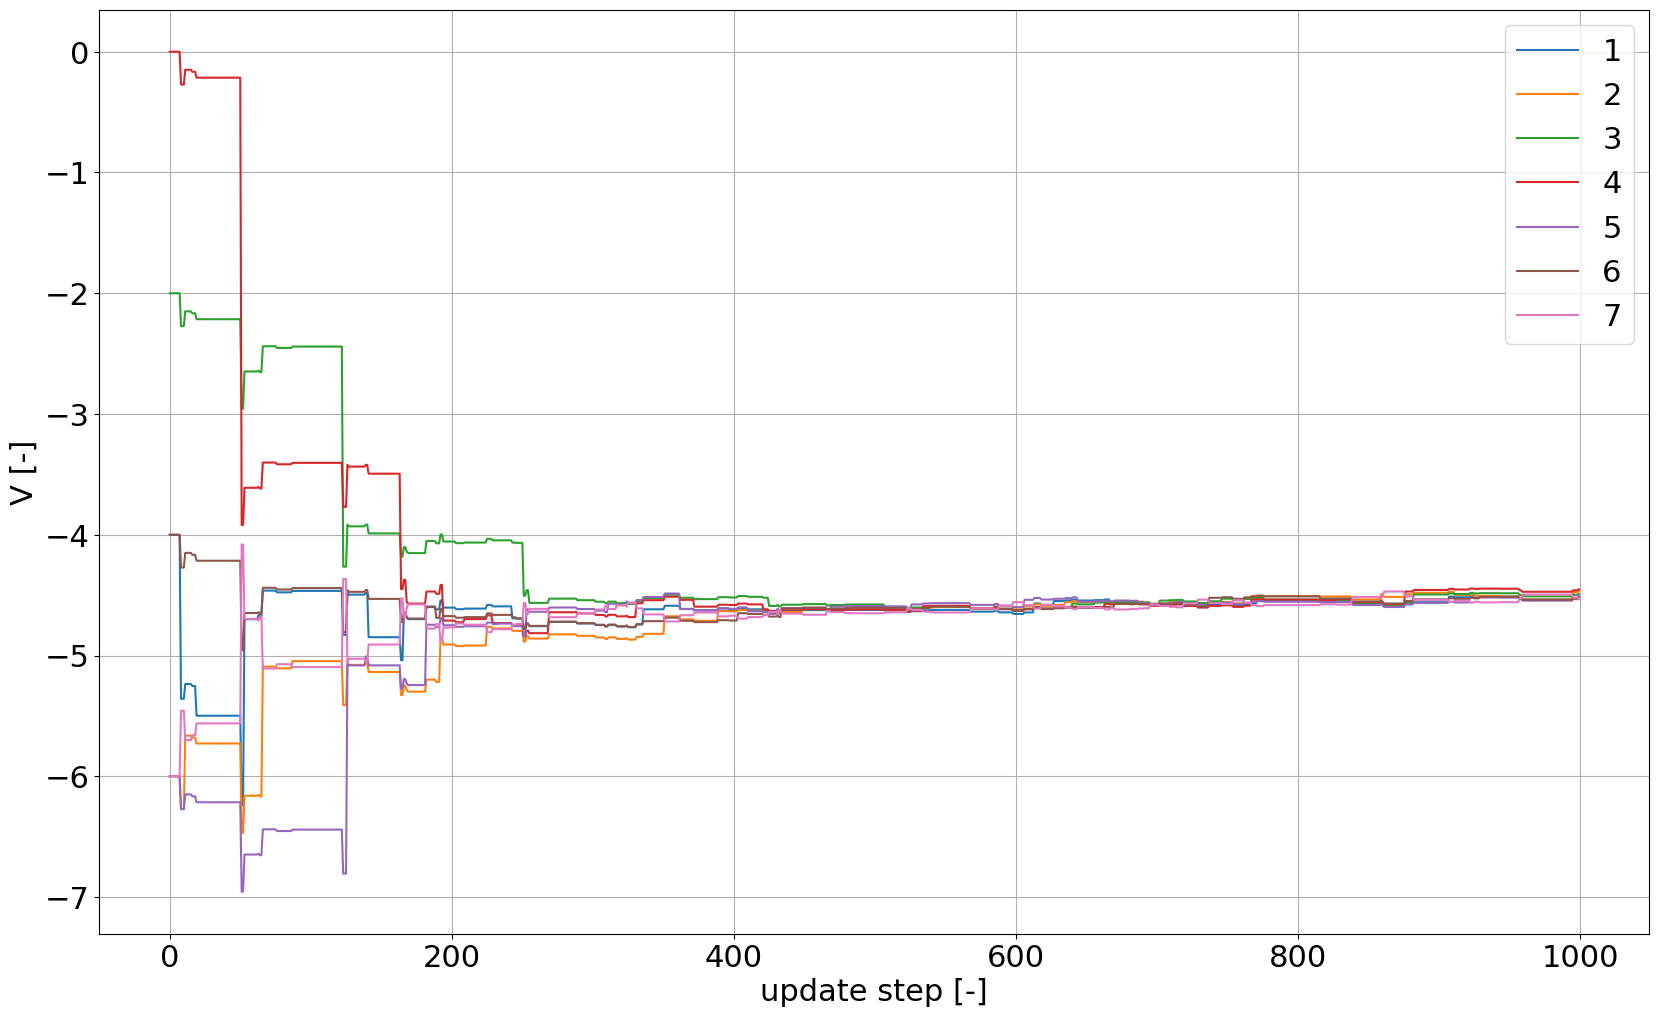

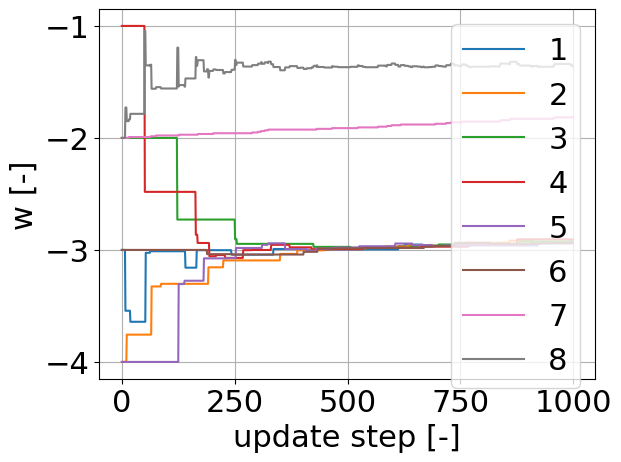

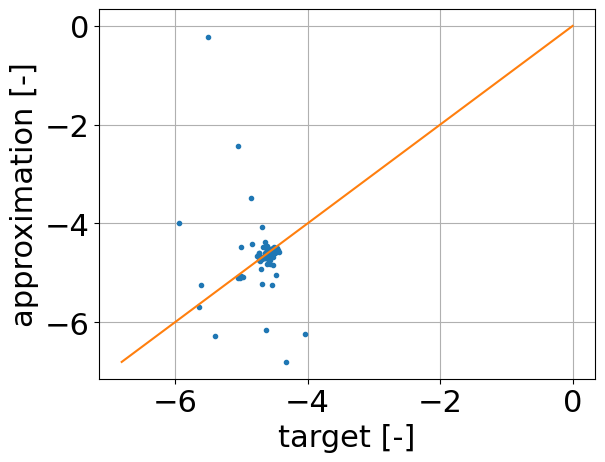

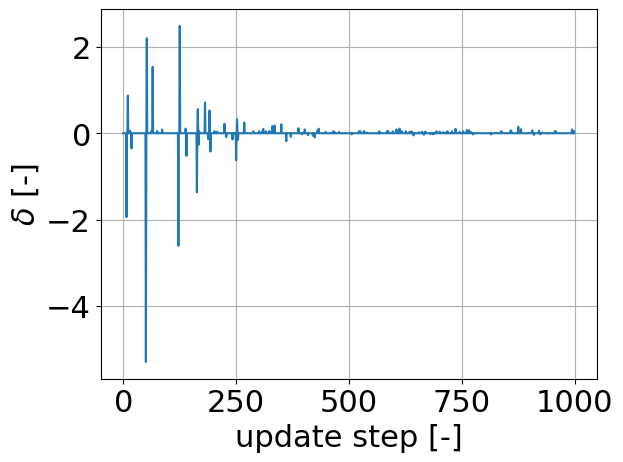

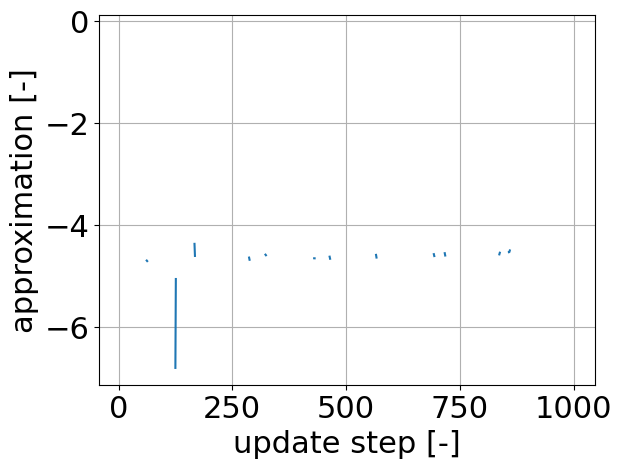

In [14]:
w, w_m, Dw8, target, approx, delta = SIGS[iSM]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[iSM])

### 💭

- Convergence rate: High

In [15]:
PERFORMANCE_INDEX.update({
                                             'sim': 3,
                                'convergence_rate': IDX__CONVERGENCE_RATE__HIGH,
    'correlation between update and approximation': IDX__CORRELATION_UPDATE_APPROX__ZERO,
                          'approximation accuracy': IDX__APPROXIMATION_ACCURACY__LOW
})

## 4

In [20]:
sim_index = 4
p8 = 0
PARS.update({
             'sim': sim_index,
               'K': 1,
    'N_iterations': 20000,
              'p8': p8,
               'X': np.array([
                    [2, 0, 0, 0, 0, 0, 0, p8],
                    [0, 2, 0, 0, 0, 0, 0, p8],
                    [0, 0, 2, 0, 0, 0, 0, p8],
                    [0, 0, 0, 2, 0, 0, 0, p8],
                    [0, 0, 0, 0, 2, 0, 0, p8],
                    [0, 0, 0, 0, 0, 2, 0, p8],
                    [0, 0, 0, 0, 0, 0, 1, 2]])
})


iSM = str(sim_index)
SIGS[iSM]  = run_MDP(PARS[iSM])


### Plots

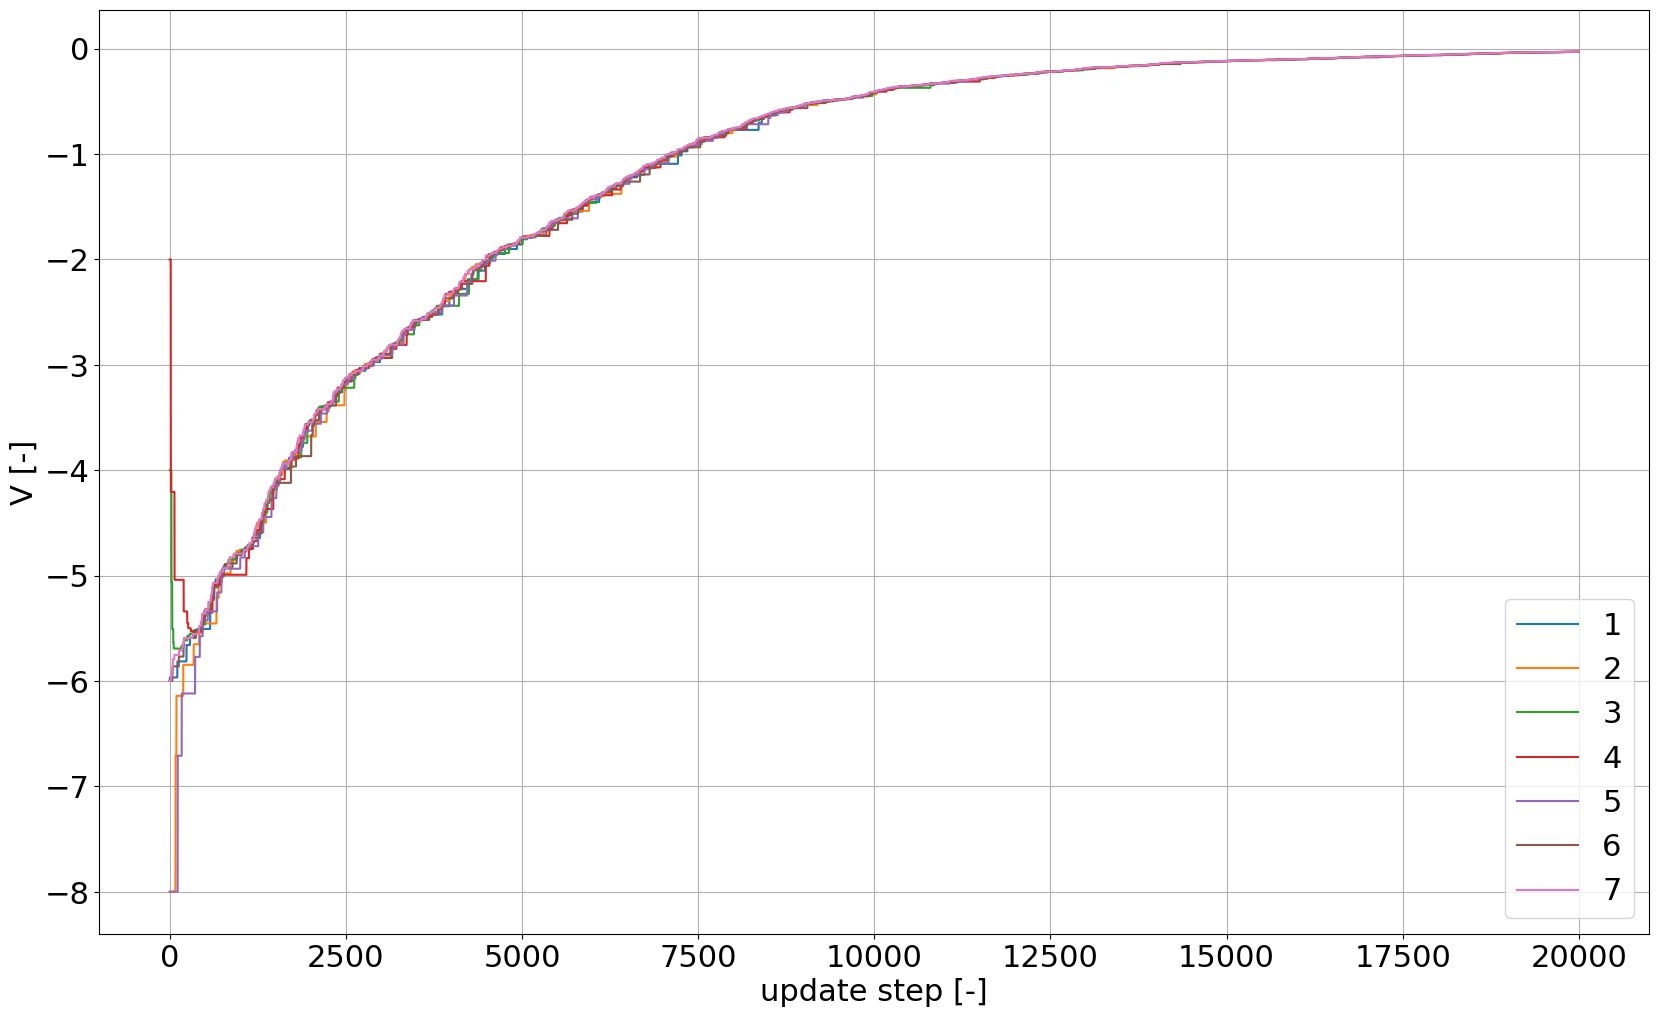

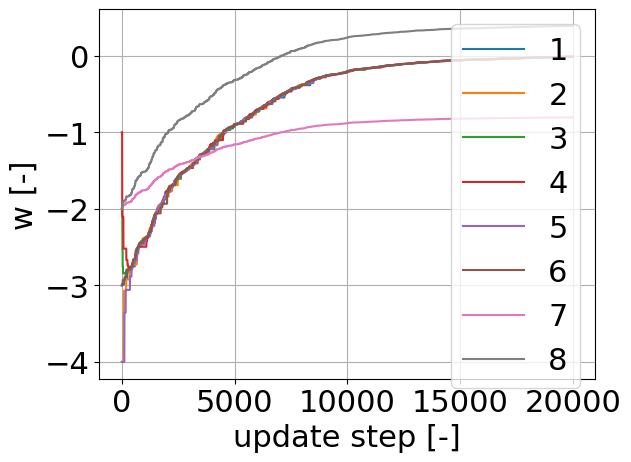

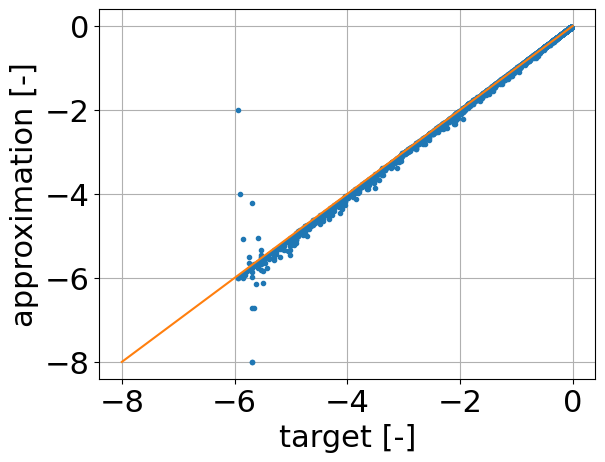

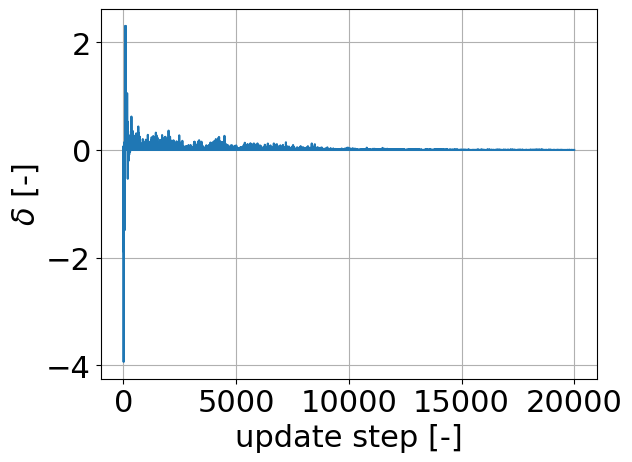

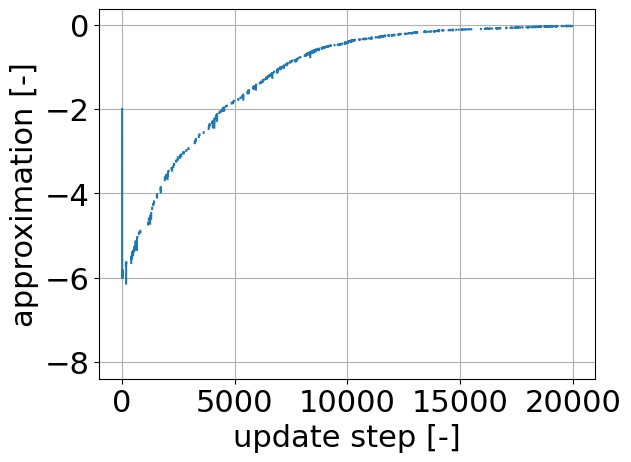

In [17]:
w, w_m, Dw8, target, approx, delta = SIGS[str(sim_index)]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[str(sim_index)])

### 💭

- Convergence is slower

In [18]:
PERFORMANCE_INDEX.update({
                                             'sim': 4,
                                'convergence_rate': IDX__CONVERGENCE_RATE__LOW,
    'correlation between update and approximation': '?',
                          'approximation accuracy': IDX__APPROXIMATION_ACCURACY__HIGH
})

## 5

In [39]:
sim_index = 5

PARS.update({
    'sim': sim_index,
      'K': 6
})


iSM = str(sim_index)
SIGS[iSM] = run_MDP(PARS[iSM])

### Plots

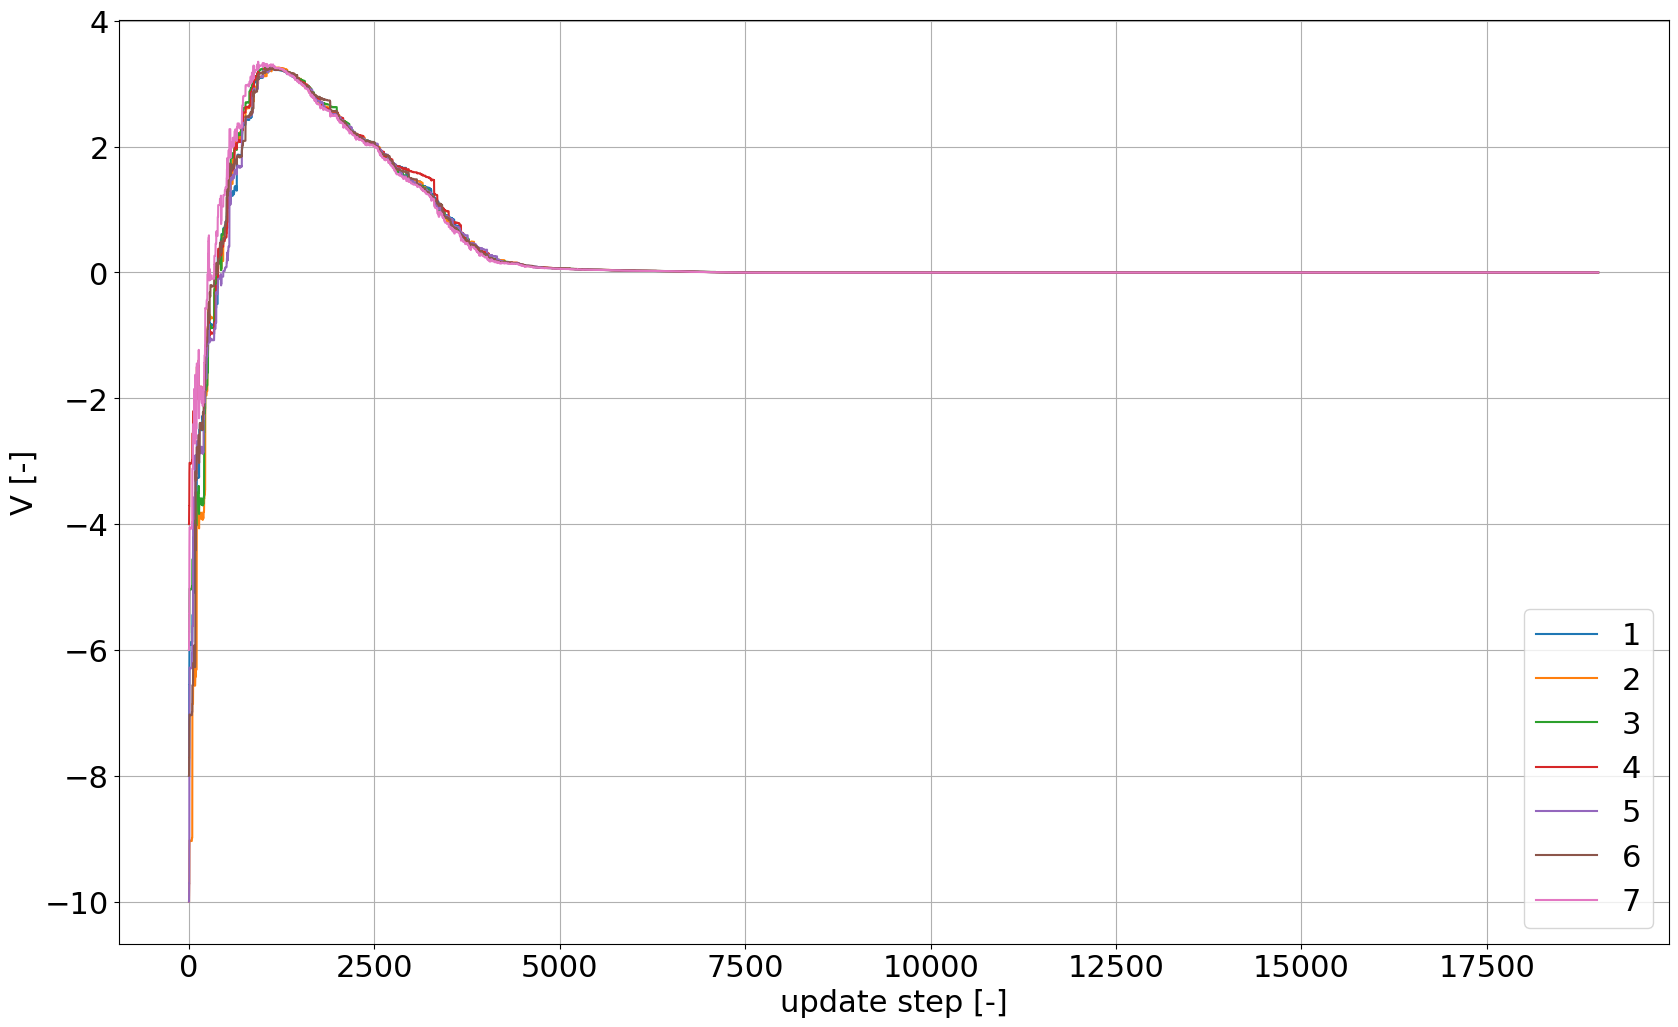

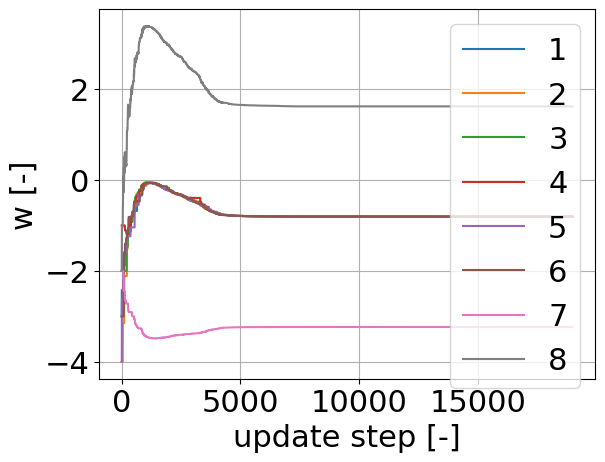

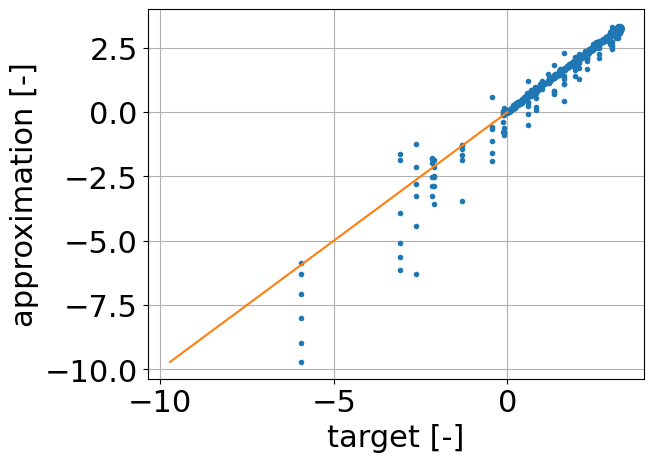

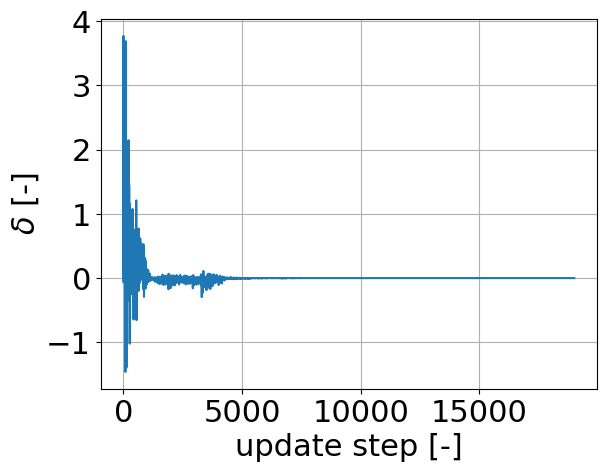

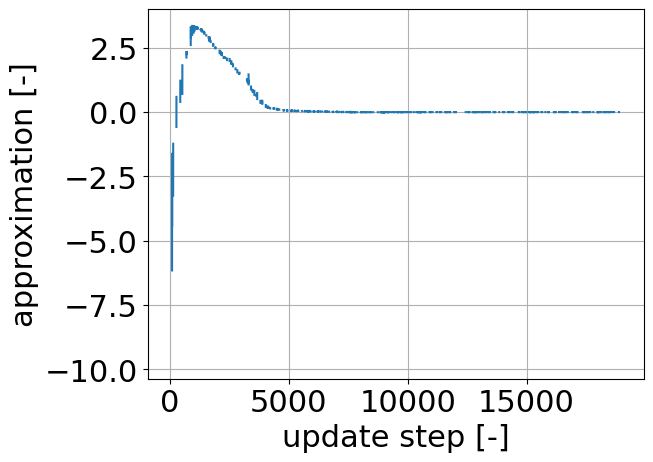

In [20]:
w, w_m, Dw8, target, approx, delta = SIGS[str(sim_index)]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[str(sim_index)])

### 💭

In [21]:
PERFORMANCE_INDEX.update({
                                             'sim': 5,
                                'convergence_rate': IDX__CONVERGENCE_RATE__HIGH,
    'correlation between update and approximation': IDX__CORRELATION_UPDATE_APPROX__HIGH,
                          'approximation accuracy': IDX__APPROXIMATION_ACCURACY__HIGH
})

## 6

In [22]:
sim_index = 6

PARS.update({
    'sim': sim_index,
      'K': 3
})

iSM = str(sim_index)
SIGS[iSM] = run_MDP(PARS[iSM])

### Plots

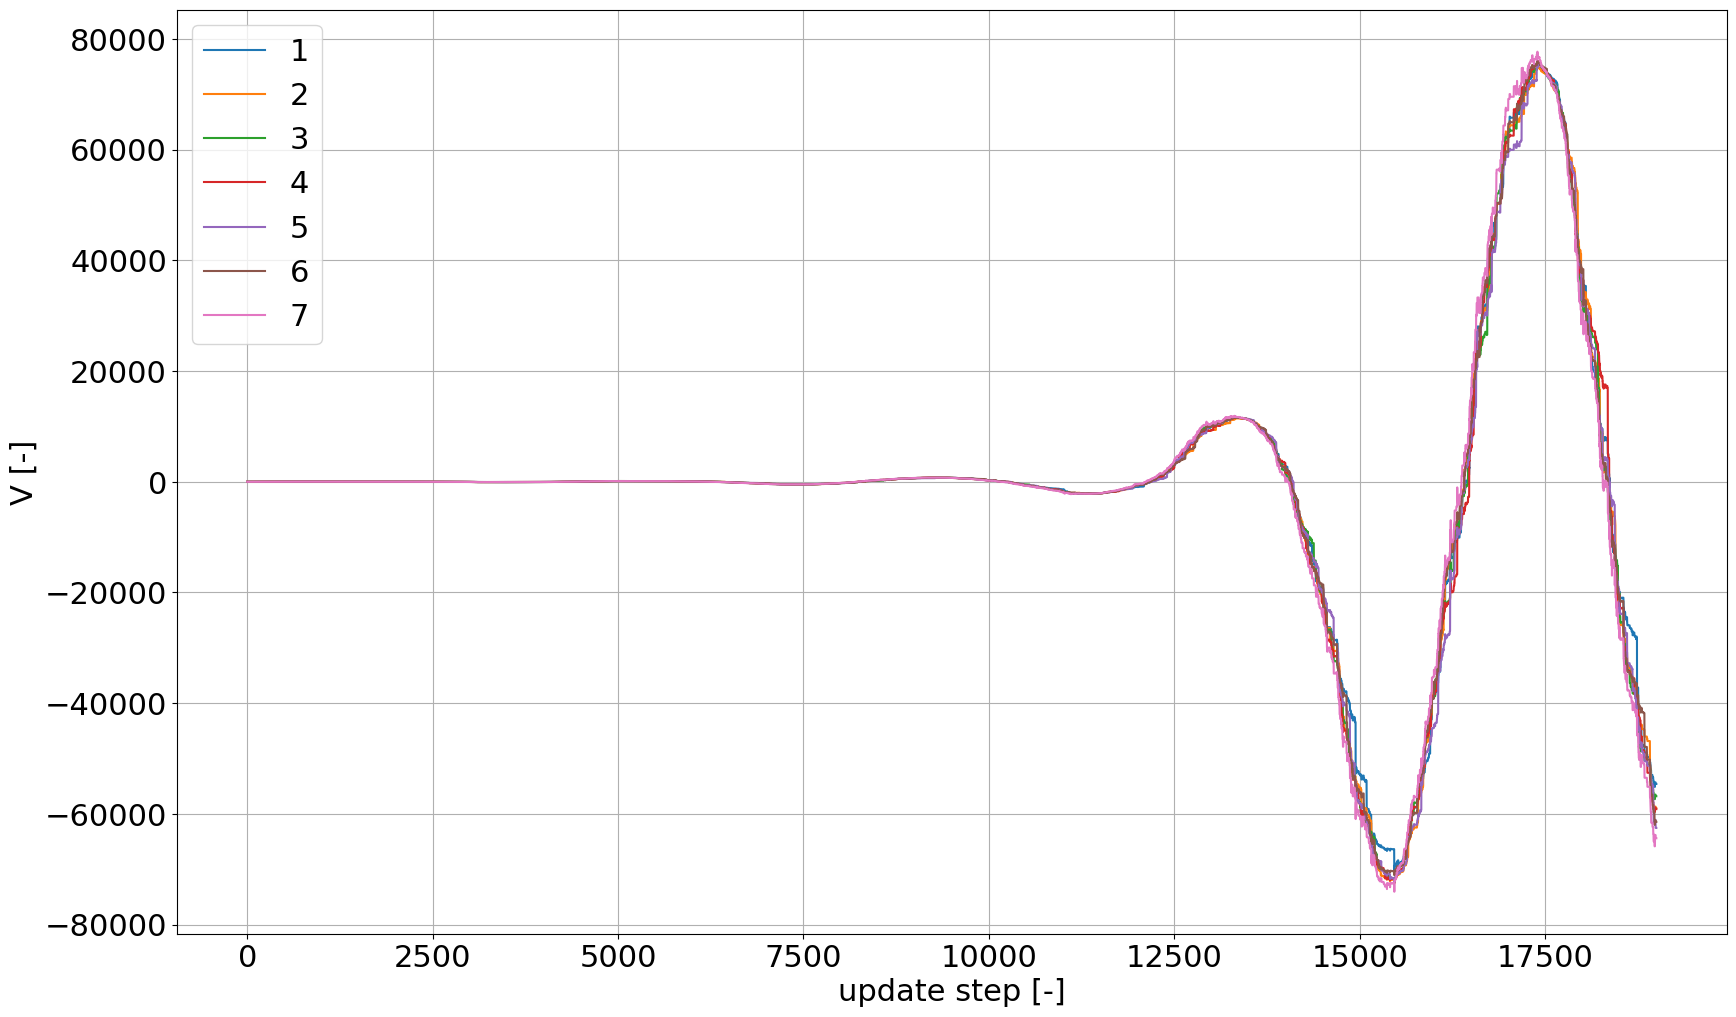

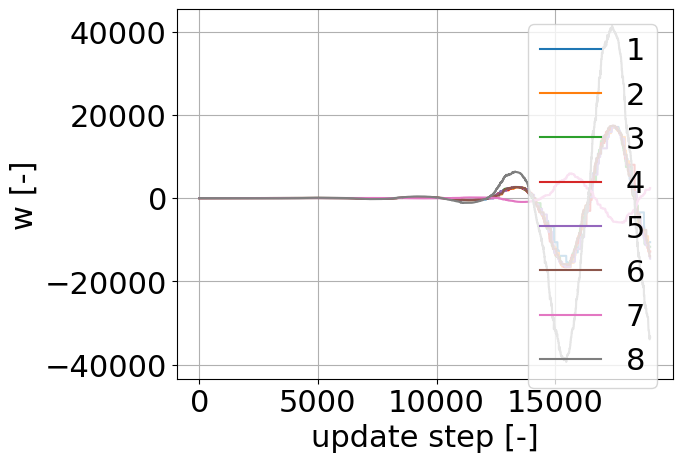

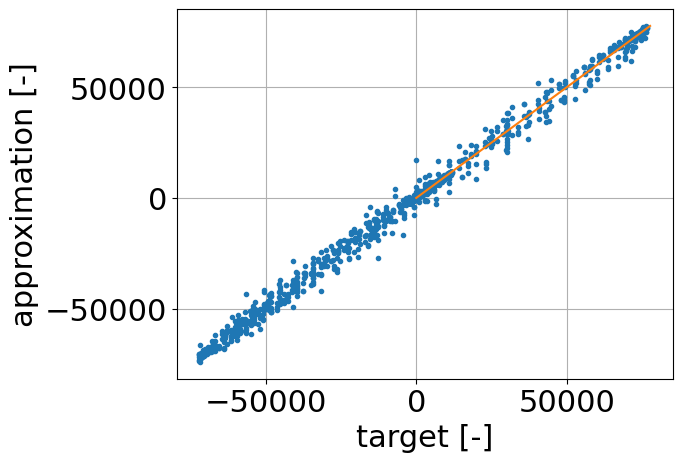

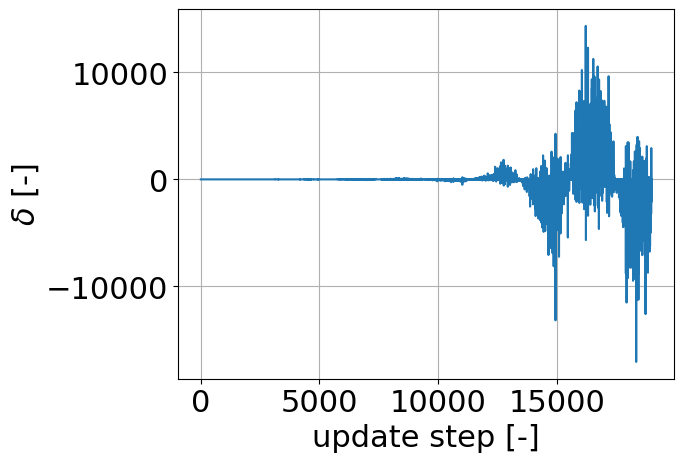

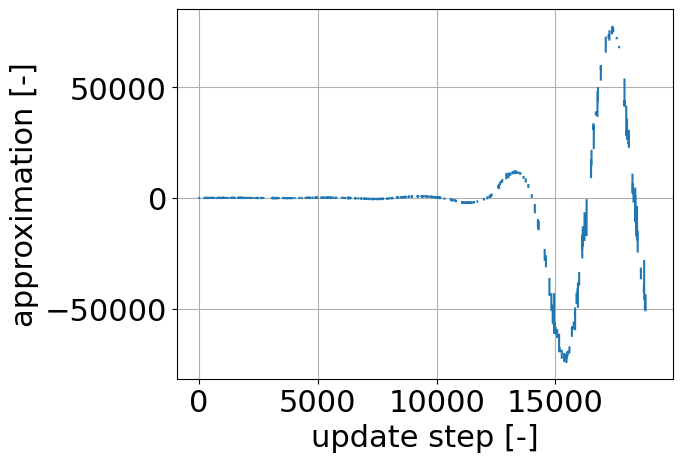

In [23]:
w, w_m, Dw8, target, approx, delta = SIGS[str(sim_index)]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[str(sim_index)])

### 💭

In [24]:
PERFORMANCE_INDEX.update({
                                             'sim': 6,
                                'convergence_rate': IDX__CONVERGENCE_RATE__DOES_NOT_CONVERGE,
    'correlation between update and approximation': IDX__CORRELATION_UPDATE_APPROX__HIGH,
                          'approximation accuracy': IDX__APPROXIMATION_ACCURACY__NOT_APPL
})

## 7

In [40]:
sim_index = 7

PARS.update({
             'sim': sim_index,
           'alpha': 0.002,
    'N_iterations': 10000}, copy_from_sim=3)



iSM = str(sim_index)
SIGS[iSM] = run_MDP(PARS[iSM])

### Plots

There's NaN values in the target!


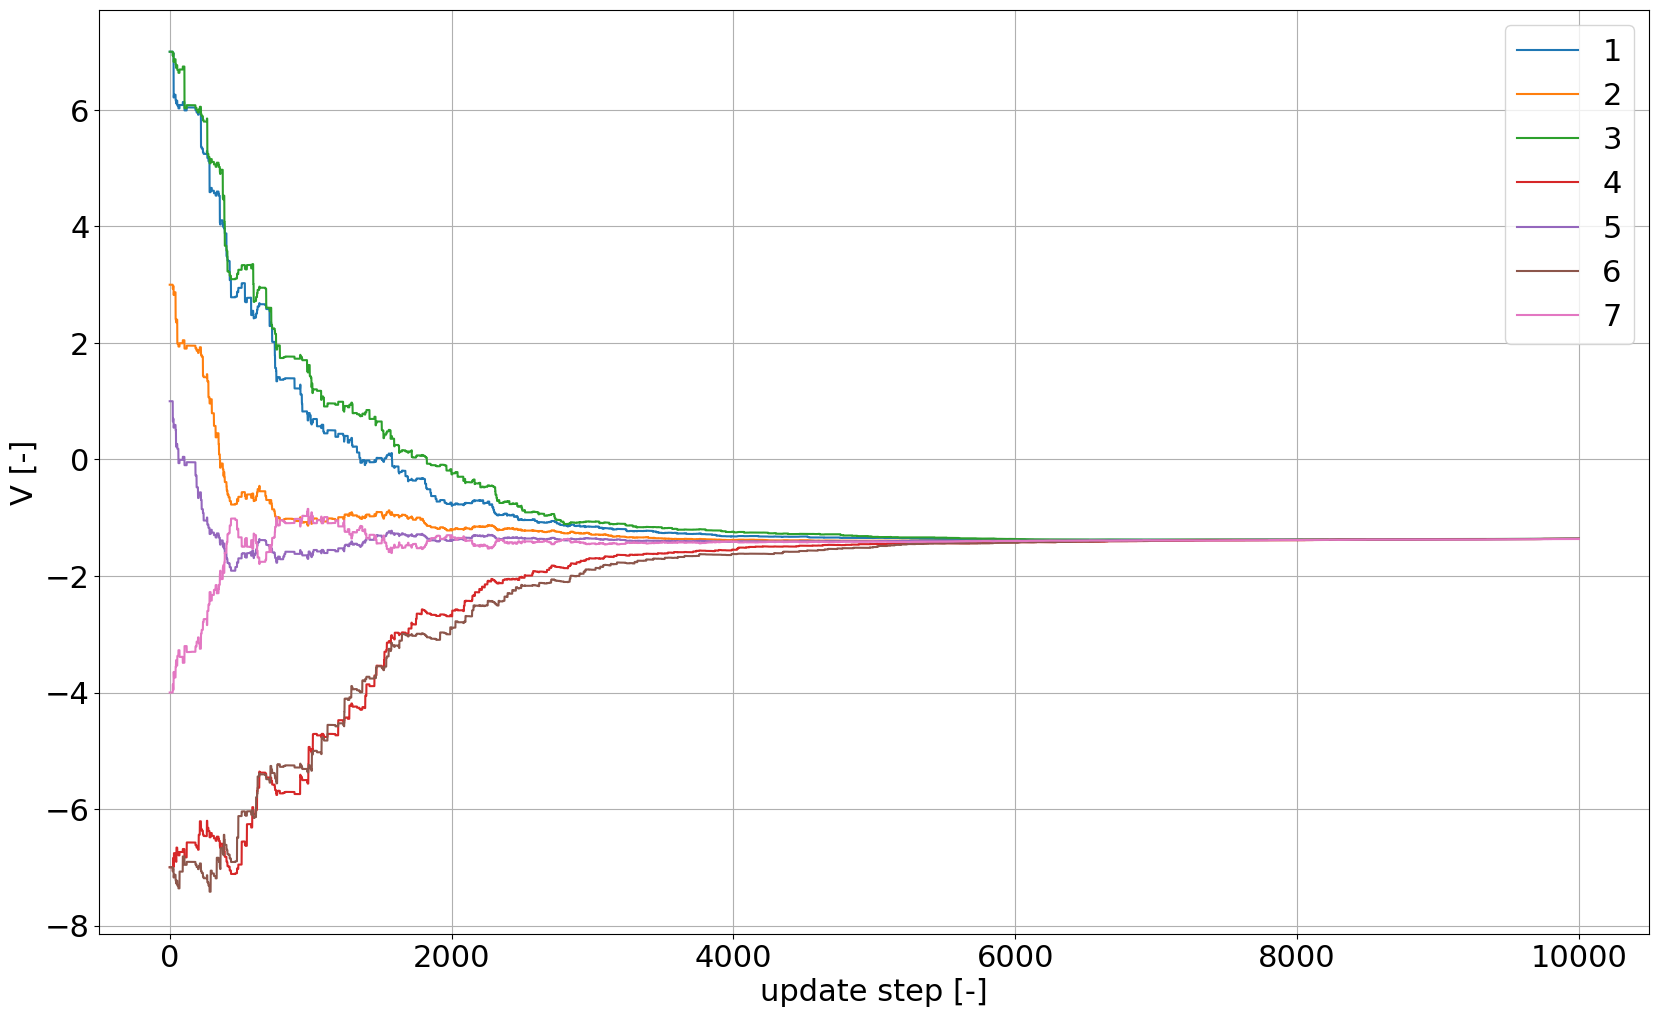

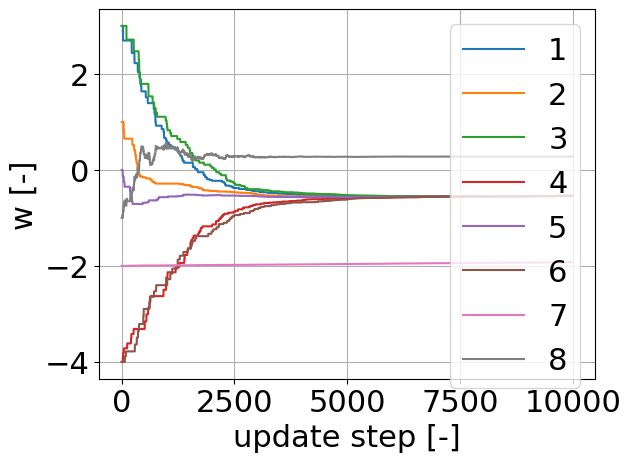

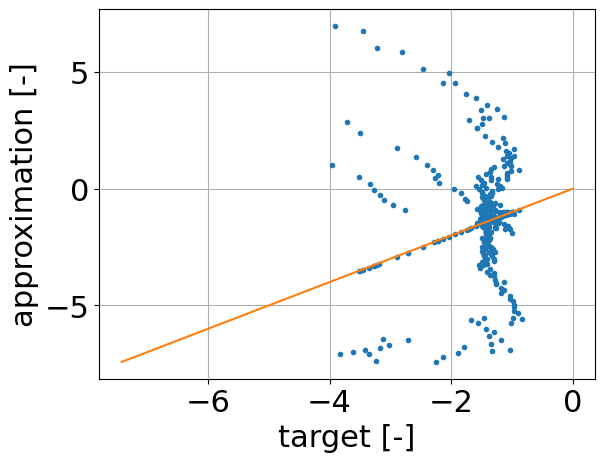

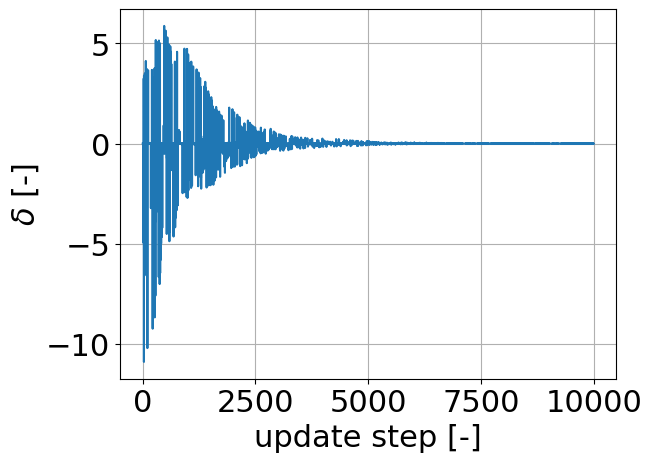

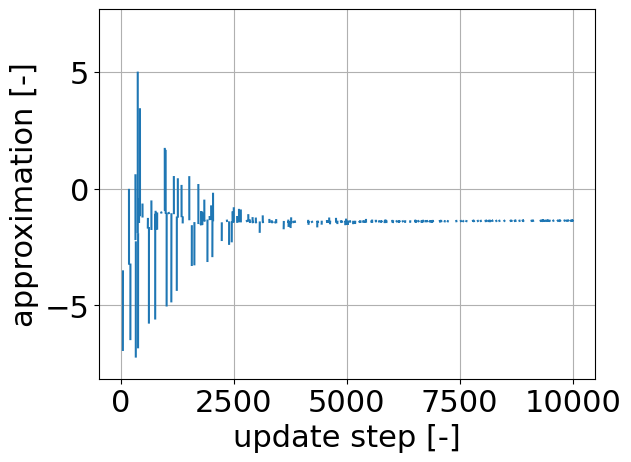

In [41]:
w, w_m, Dw8, target, approx, delta = SIGS[str(sim_index)]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[str(sim_index)])

### 💭
- Reducing the stepsize does not improve the approximation accuracy (where it converges)

In [28]:
PERFORMANCE_INDEX.update({
                                             'sim': 7,
                                'convergence_rate': IDX__CONVERGENCE_RATE__MEDIUM,
    'correlation between update and approximation': IDX__CORRELATION_UPDATE_APPROX__ZERO,
                          'approximation accuracy': IDX__APPROXIMATION_ACCURACY__LOW
})

## 8

In [24]:
sim_index = 8

PARS.update({
      'sim': sim_index,
    'alpha': 0.07}, idx_copy=5)

SIGS[str(sim_index)] = run_MDP(PARS[str(sim_index)])

### Plots

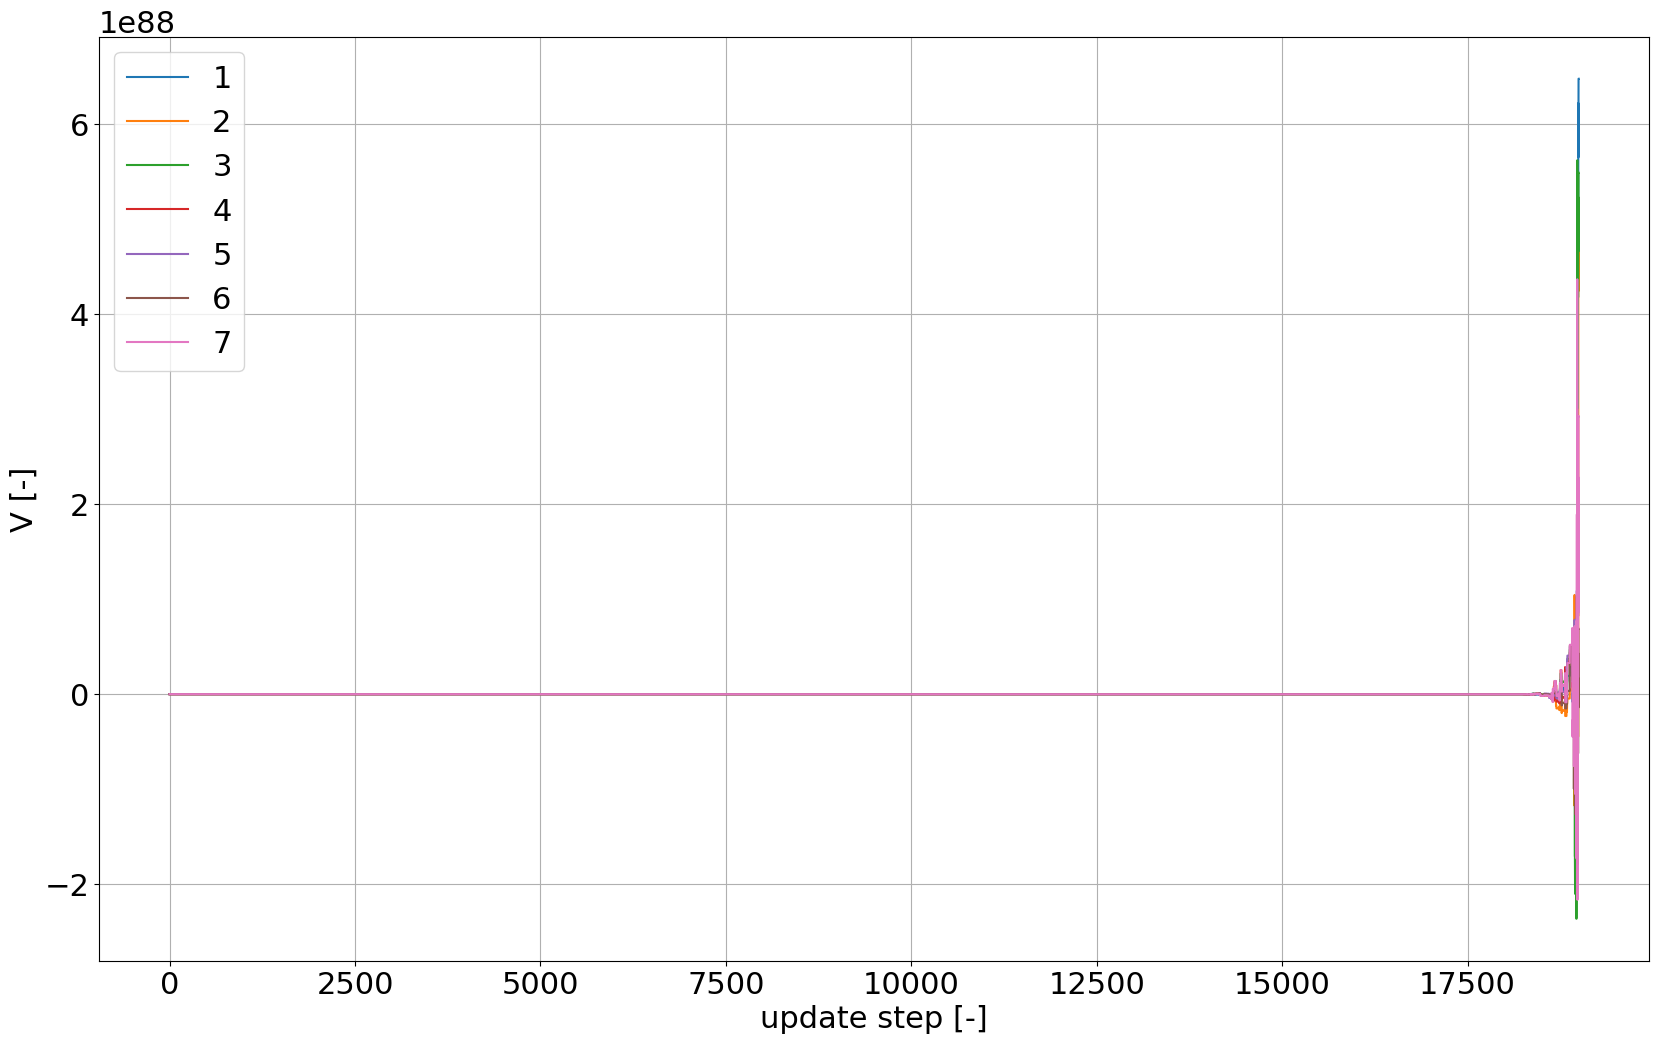

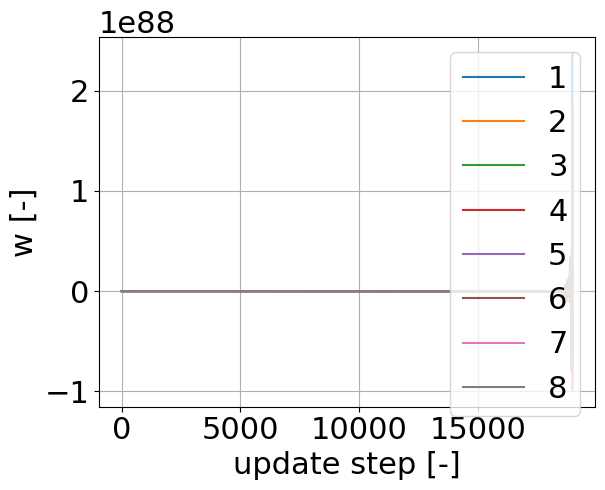

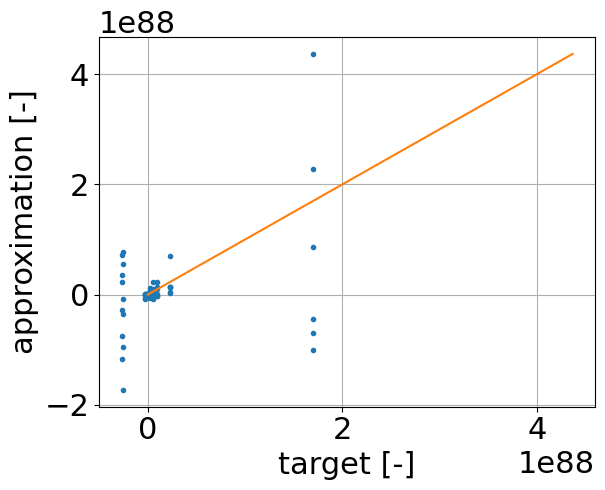

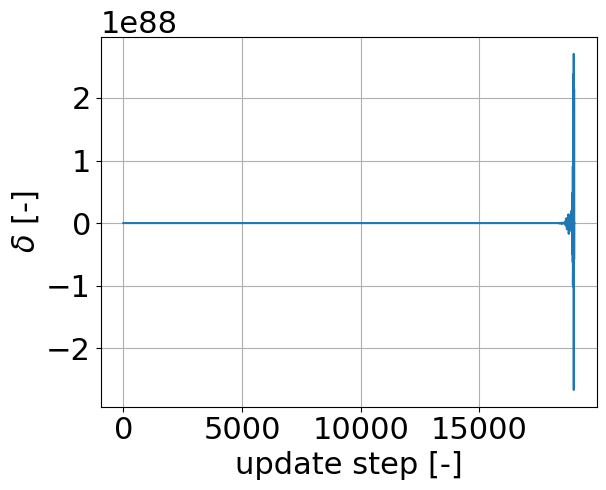

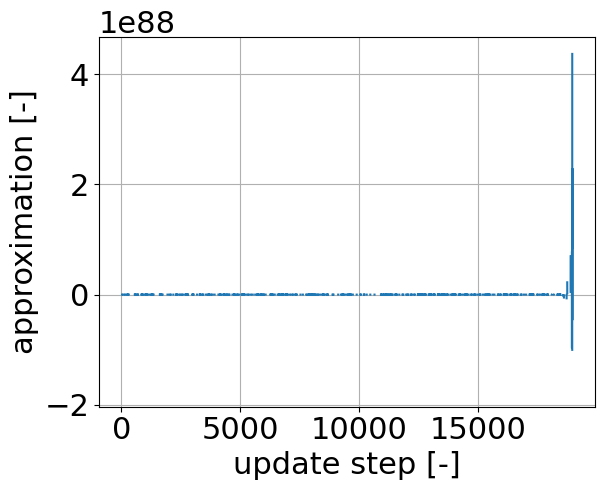

In [30]:
w, w_m, Dw8, target, approx, delta = SIGS[str(sim_index)]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[str(sim_index)])

### 💭
- Reducing the stepsize does not improve the approximation accuracy (where it converges)

In [31]:
PERFORMANCE_INDEX.update({
                                             'sim': 8,
                                'convergence_rate': IDX__CONVERGENCE_RATE__DOES_NOT_CONVERGE,
    'correlation between update and approximation': IDX__CORRELATION_UPDATE_APPROX__ZERO,
                          'approximation accuracy': IDX__APPROXIMATION_ACCURACY__NOT_APPL
})

## 9 ⚠

In [25]:
sim_index = 9

PARS.update({
    'sim': sim_index,
    'alpha': 0.01}, copy_from_sim=5)

SIGS[str(sim_index)] = run_MDP(PARS[str(sim_index)])

### Plots

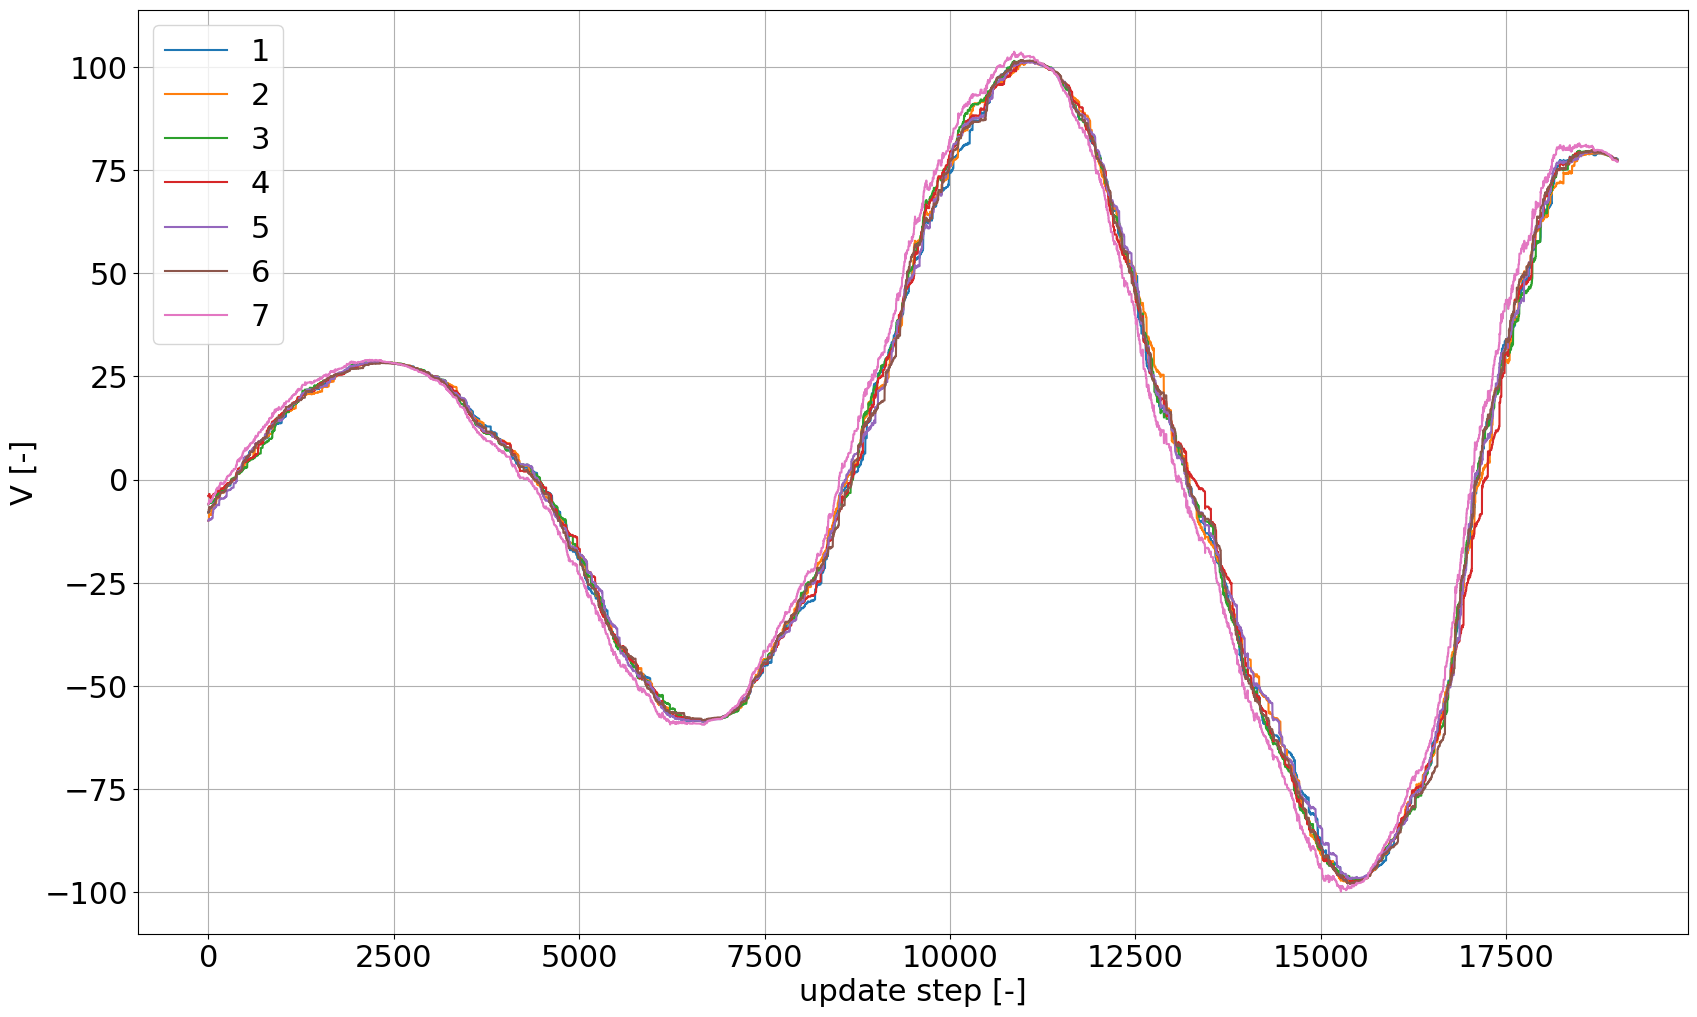

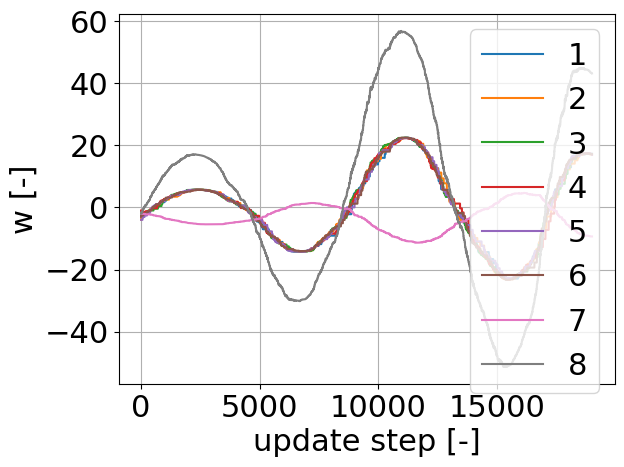

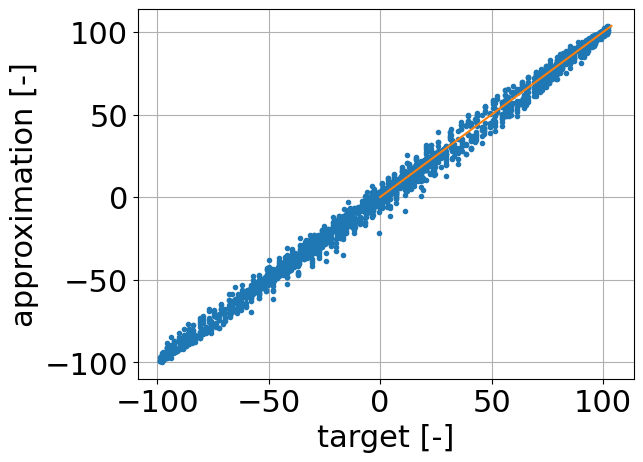

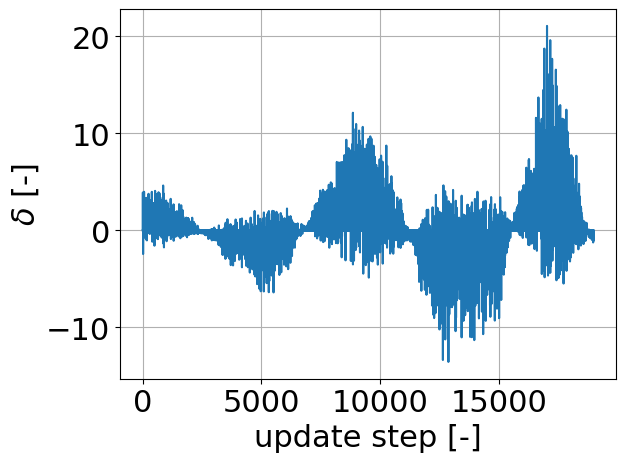

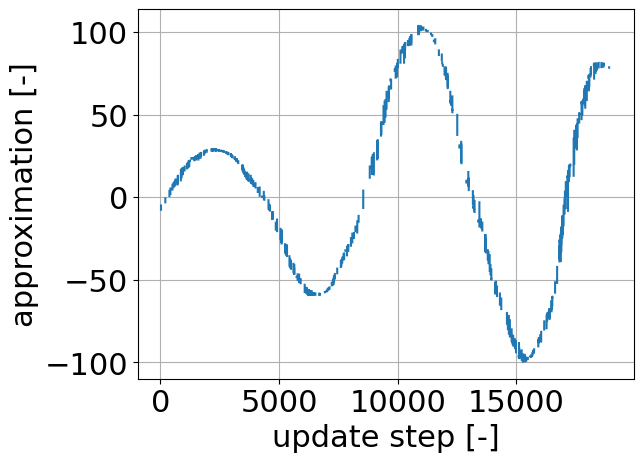

In [33]:
w, w_m, Dw8, target, approx, delta = SIGS[str(sim_index)]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[str(sim_index)])

### 💭
- ⚠🤷‍♀️ How is it that reducing the step size generates worse results?

In [34]:
sim_index = 9
PERFORMANCE_INDEX.update({
                                             'sim': str(sim_index) + ' ⚠',
                                'convergence_rate': IDX__CONVERGENCE_RATE__DOES_NOT_CONVERGE,
    'correlation between update and approximation': IDX__CORRELATION_UPDATE_APPROX__HIGH,
                          'approximation accuracy': IDX__APPROXIMATION_ACCURACY__NOT_APPL
})

## 10 ⚠

In [26]:
sim_index = 10

PARS.update({
             'sim': sim_index,
           'alpha': 0.005,
    'N_iterations': 35000}, idx_copy=5)

SIGS[str(sim_index)] = run_MDP(PARS[str(sim_index)])

### Plots

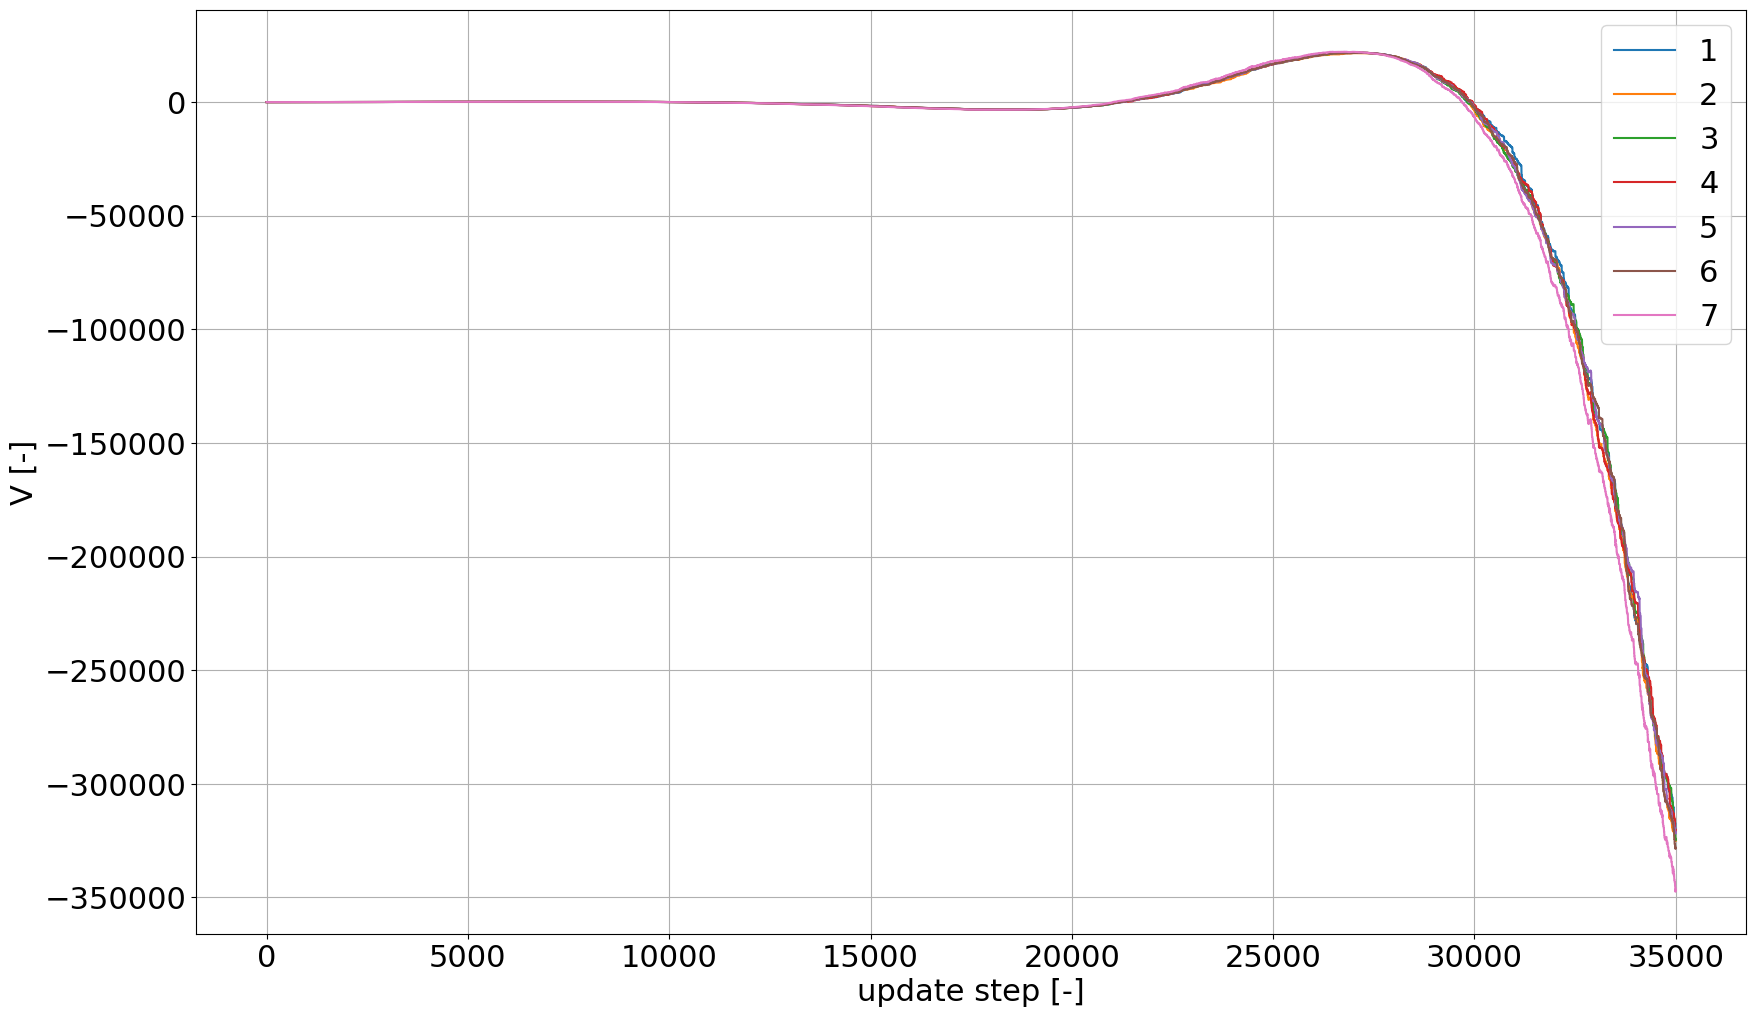

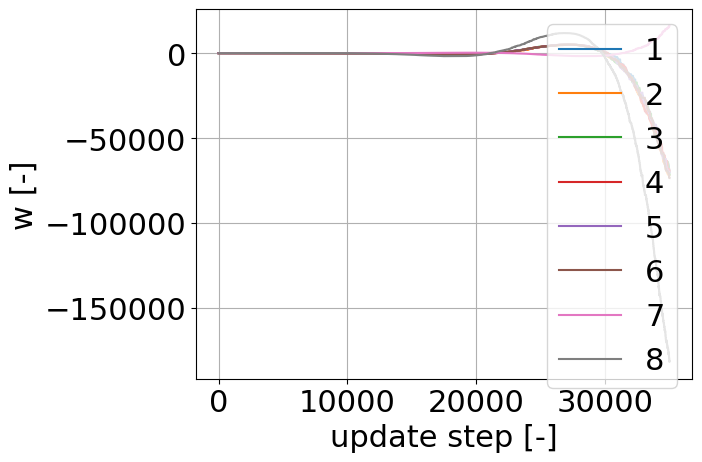

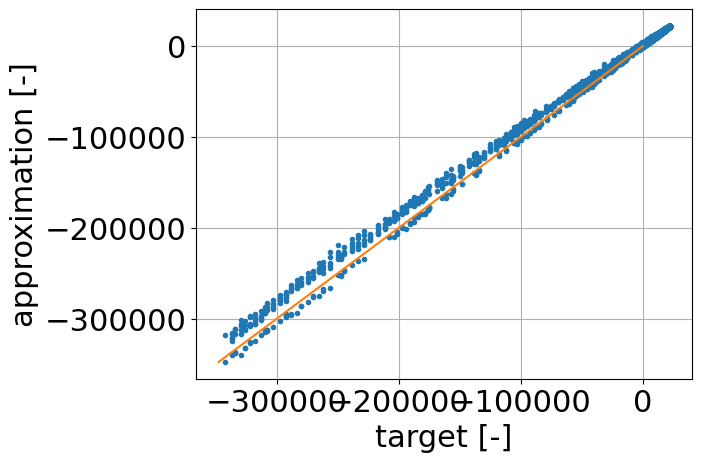

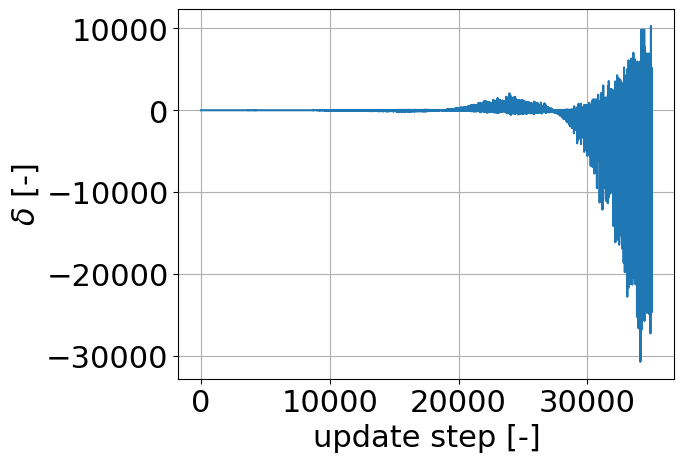

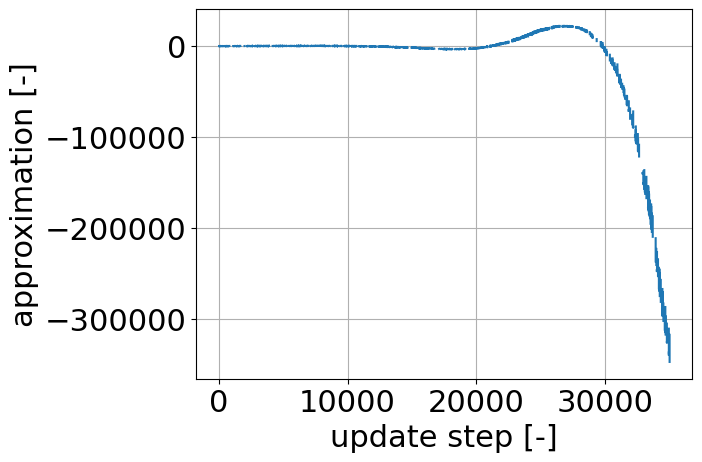

In [36]:
w, w_m, Dw8, target, approx, delta = SIGS[str(sim_index)]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[str(sim_index)])

### 💭
- ⚠🤷‍♀️ How is it that reducing the step size generates worse results?

In [42]:
sim_index = 10

PERFORMANCE_INDEX.update({
                                             'sim': str(sim_index) + ' ⚠',
                                'convergence_rate': IDX__CONVERGENCE_RATE__DOES_NOT_CONVERGE,
    'correlation between update and approximation': IDX__CORRELATION_UPDATE_APPROX__HIGH,
                          'approximation accuracy': IDX__APPROXIMATION_ACCURACY__NOT_APPL

})


## 11

In [33]:
sim_index = 11

PARS.update({
             'sim': sim_index,
           'alpha': 0.012,
    'N_iterations': 35000}, idx_copy=5)


iSm = str(sim_index)
SIGS[iSm] = run_MDP(PARS[iSm])

### Plots

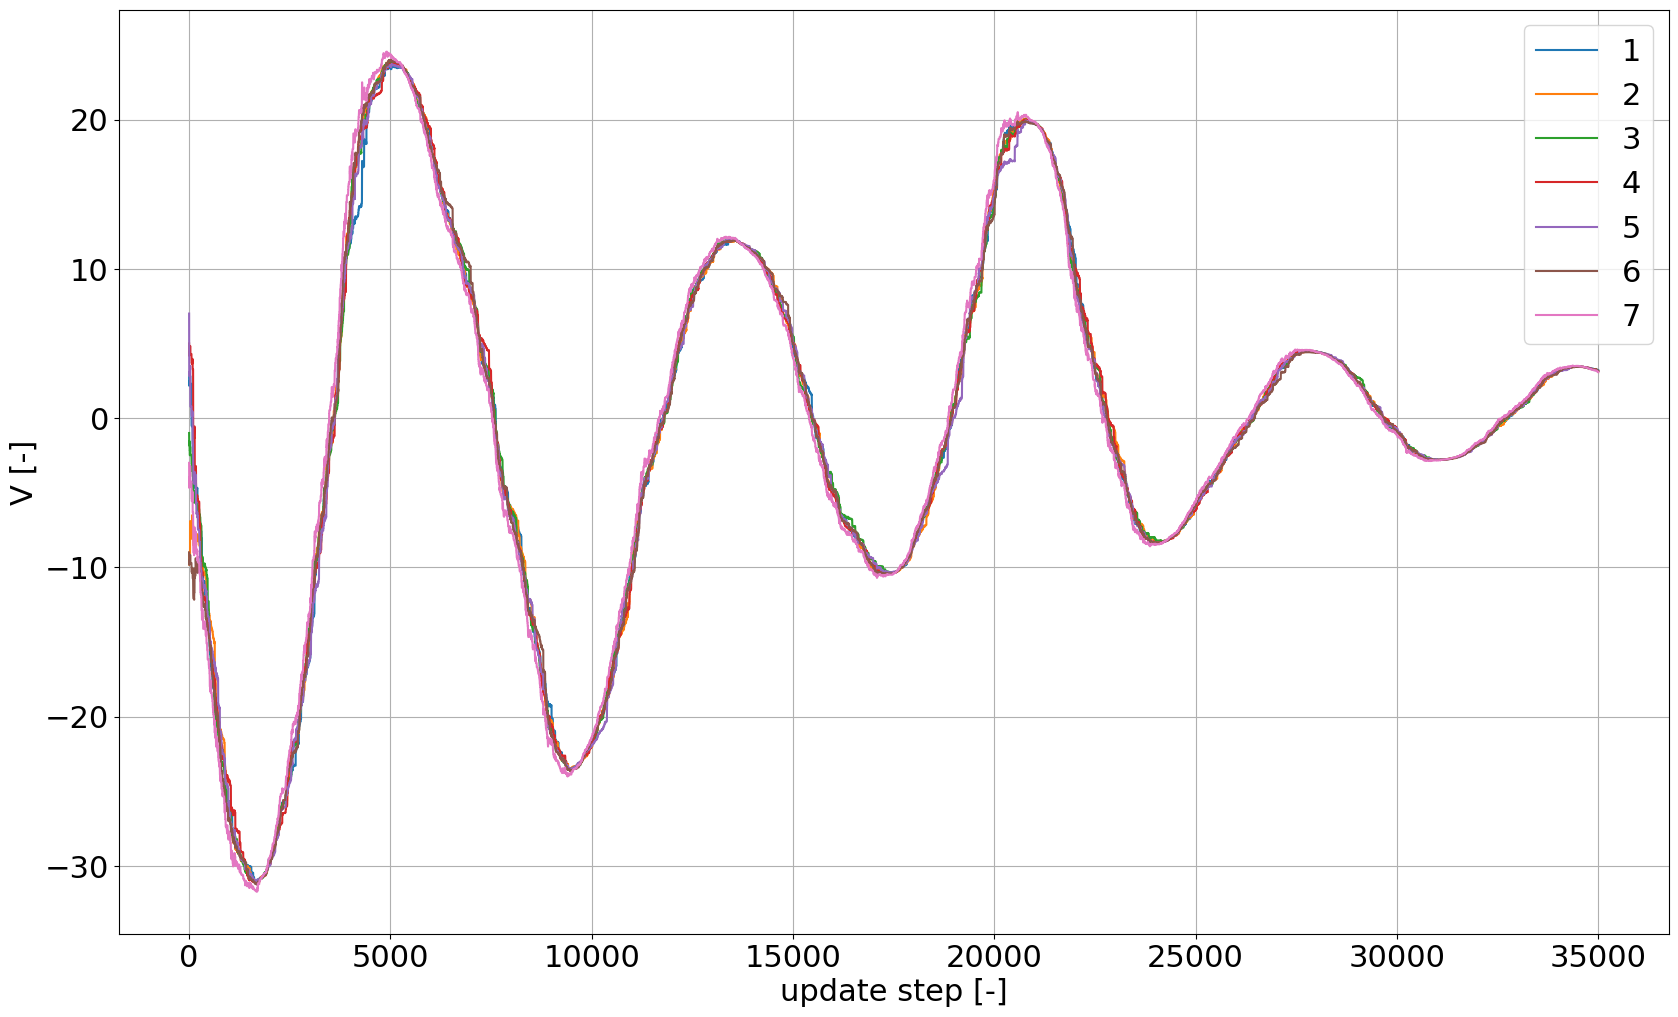

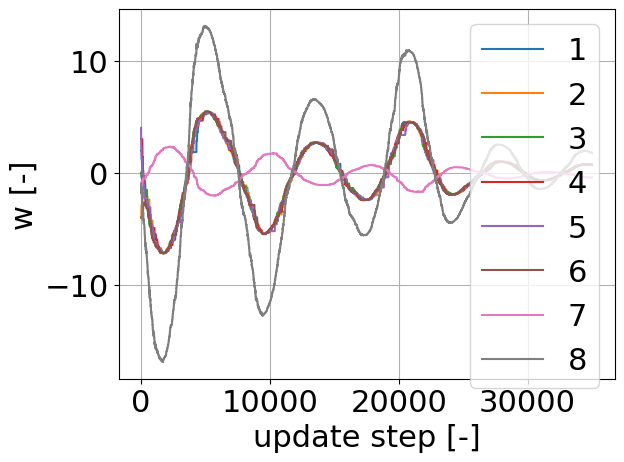

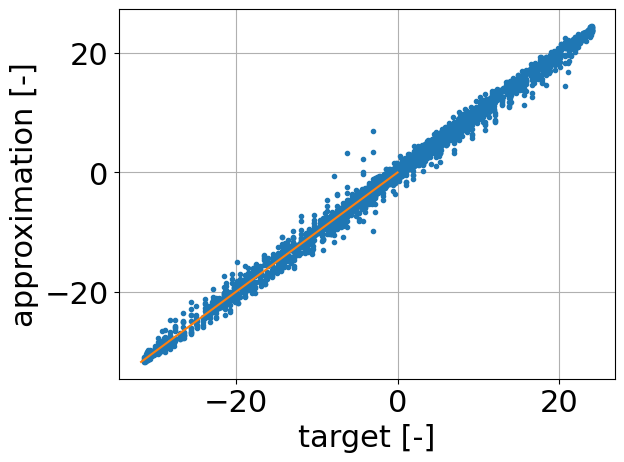

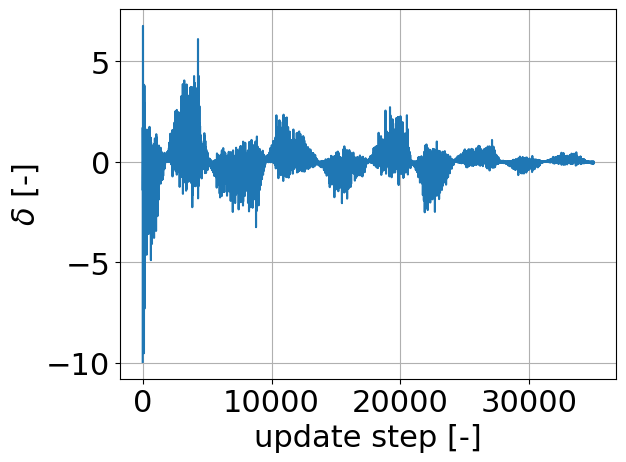

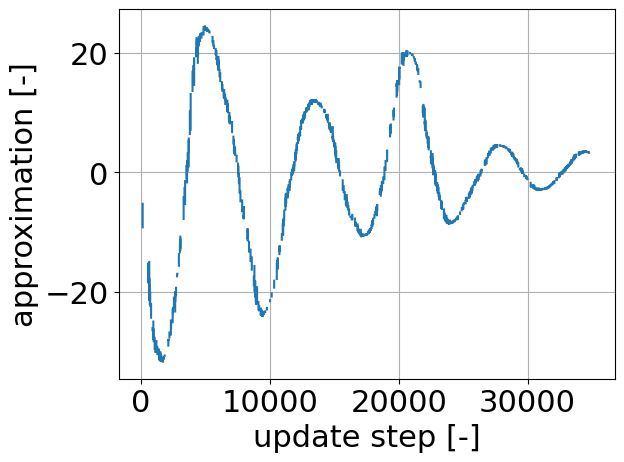

In [34]:
w, w_m, Dw8, target, approx, delta = SIGS[str(sim_index)]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[str(sim_index)])

### 💭
- Getting stabilized --> finding a "sweet spot"

In [43]:
PERFORMANCE_INDEX.update({
                                             'sim': '11 ⚠',
                                'convergence_rate': IDX__CONVERGENCE_RATE__EXTREMELY_LOW,
    'correlation between update and approximation': IDX__CORRELATION_UPDATE_APPROX__HIGH,
                          'approximation accuracy': IDX__APPROXIMATION_ACCURACY__LOW

})

## 12

In [48]:
sim_index = 12

PARS.update({
    'sim': sim_index,
      'b': np.array([1/2, 1/2])}, 
     idx_copy=7)

SIGS[str(sim_index)] = run_MDP(PARS[str(sim_index)])

### Plots

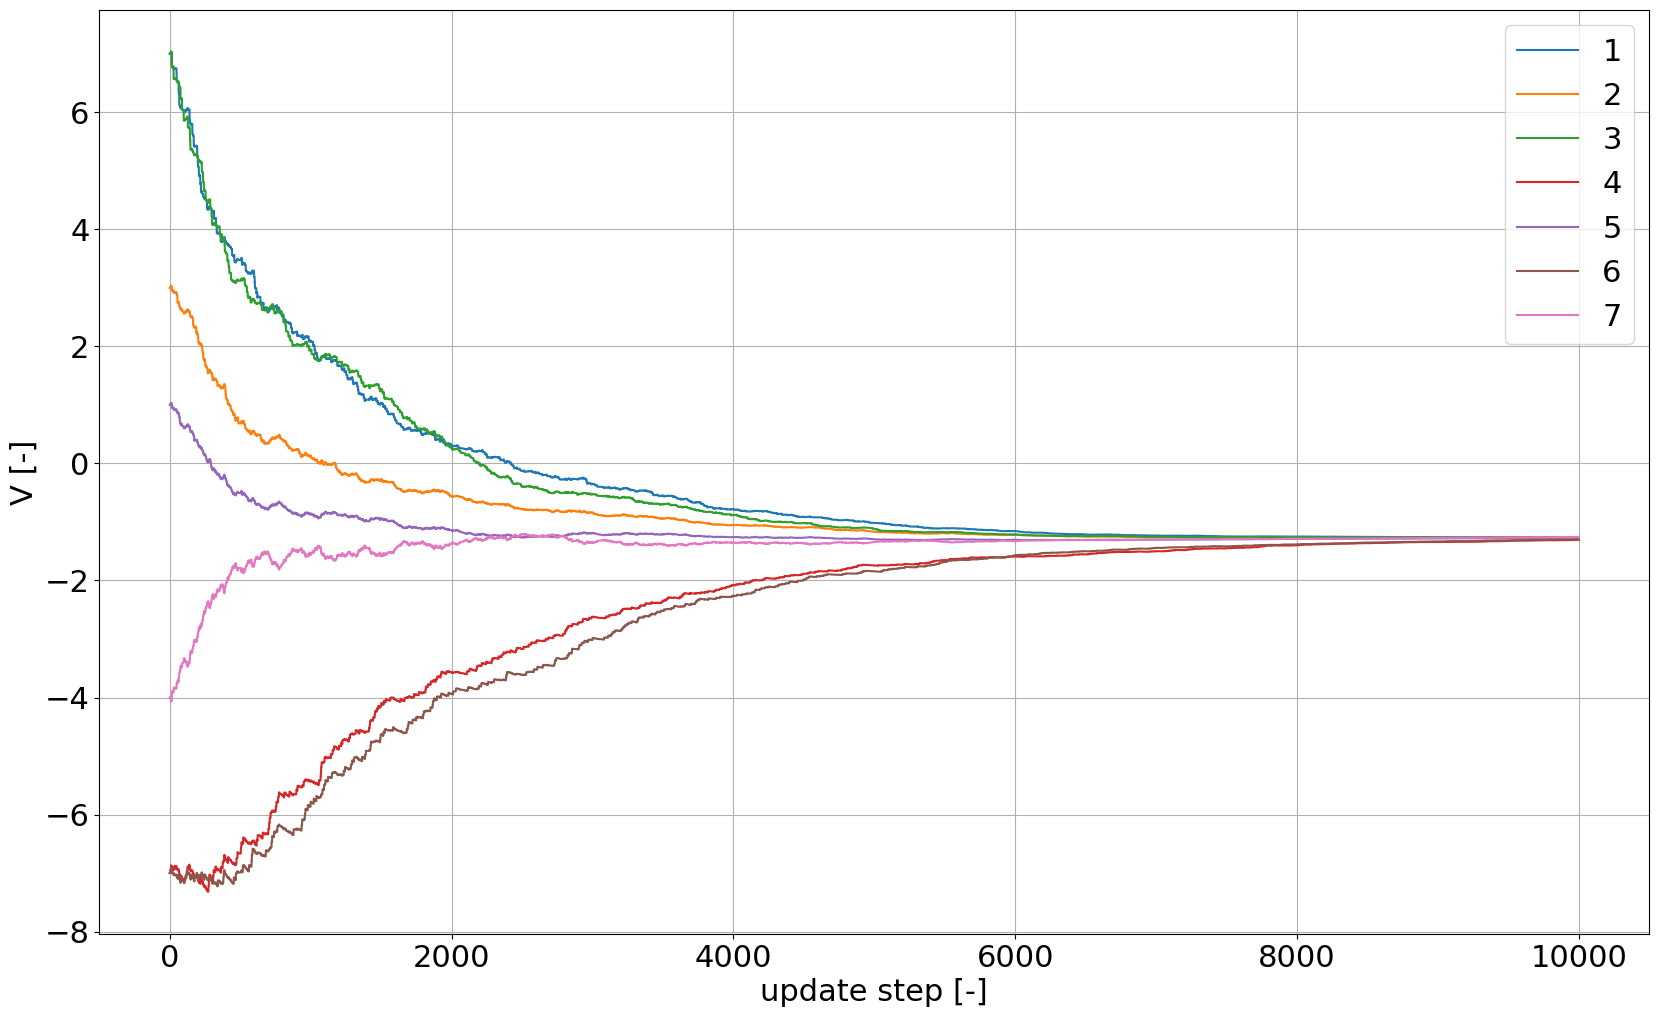

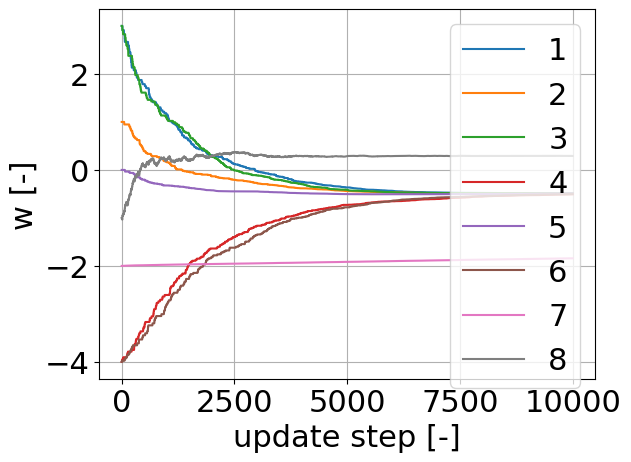

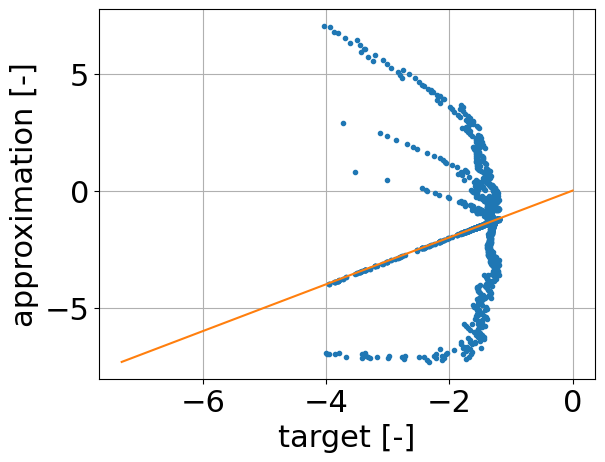

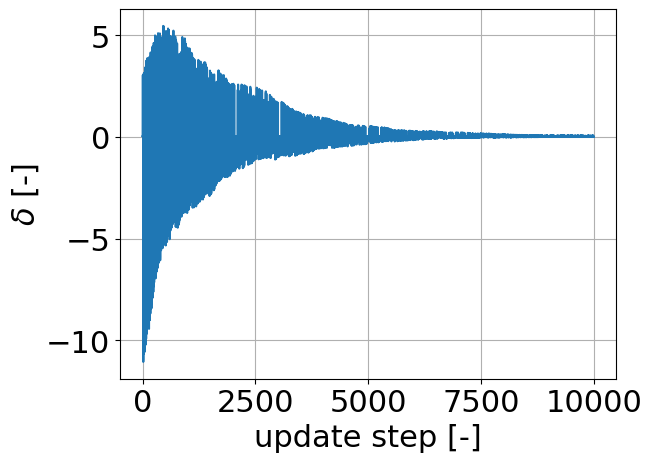

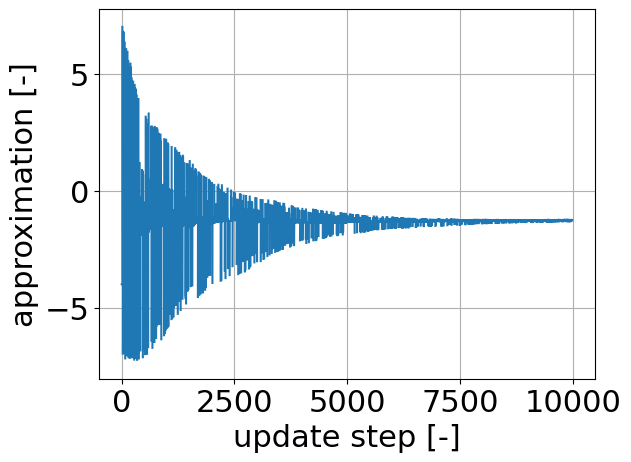

In [49]:
w, w_m, Dw8, target, approx, delta = SIGS[str(sim_index)]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[str(sim_index)])

### 💭
- Getting stabilized --> finding a "sweet spot"

In [47]:
PERFORMANCE_INDEX.update({
                                             'sim': '12',
                                'convergence_rate': IDX__CONVERGENCE_RATE__LOW,
    'correlation between update and approximation': IDX__CORRELATION_UPDATE_APPROX__ZERO,
                          'approximation accuracy': IDX__APPROXIMATION_ACCURACY__LOW

})

## 13

In [46]:
sim_index = 13

PARS.update({
              'sim': sim_index,
                'K': 1,
            'alpha': 0.0002,                
     'N_iterations': 3500})

SIGS[str(sim_index)] = run_MDP(PARS[str(sim_index)])

### Plots

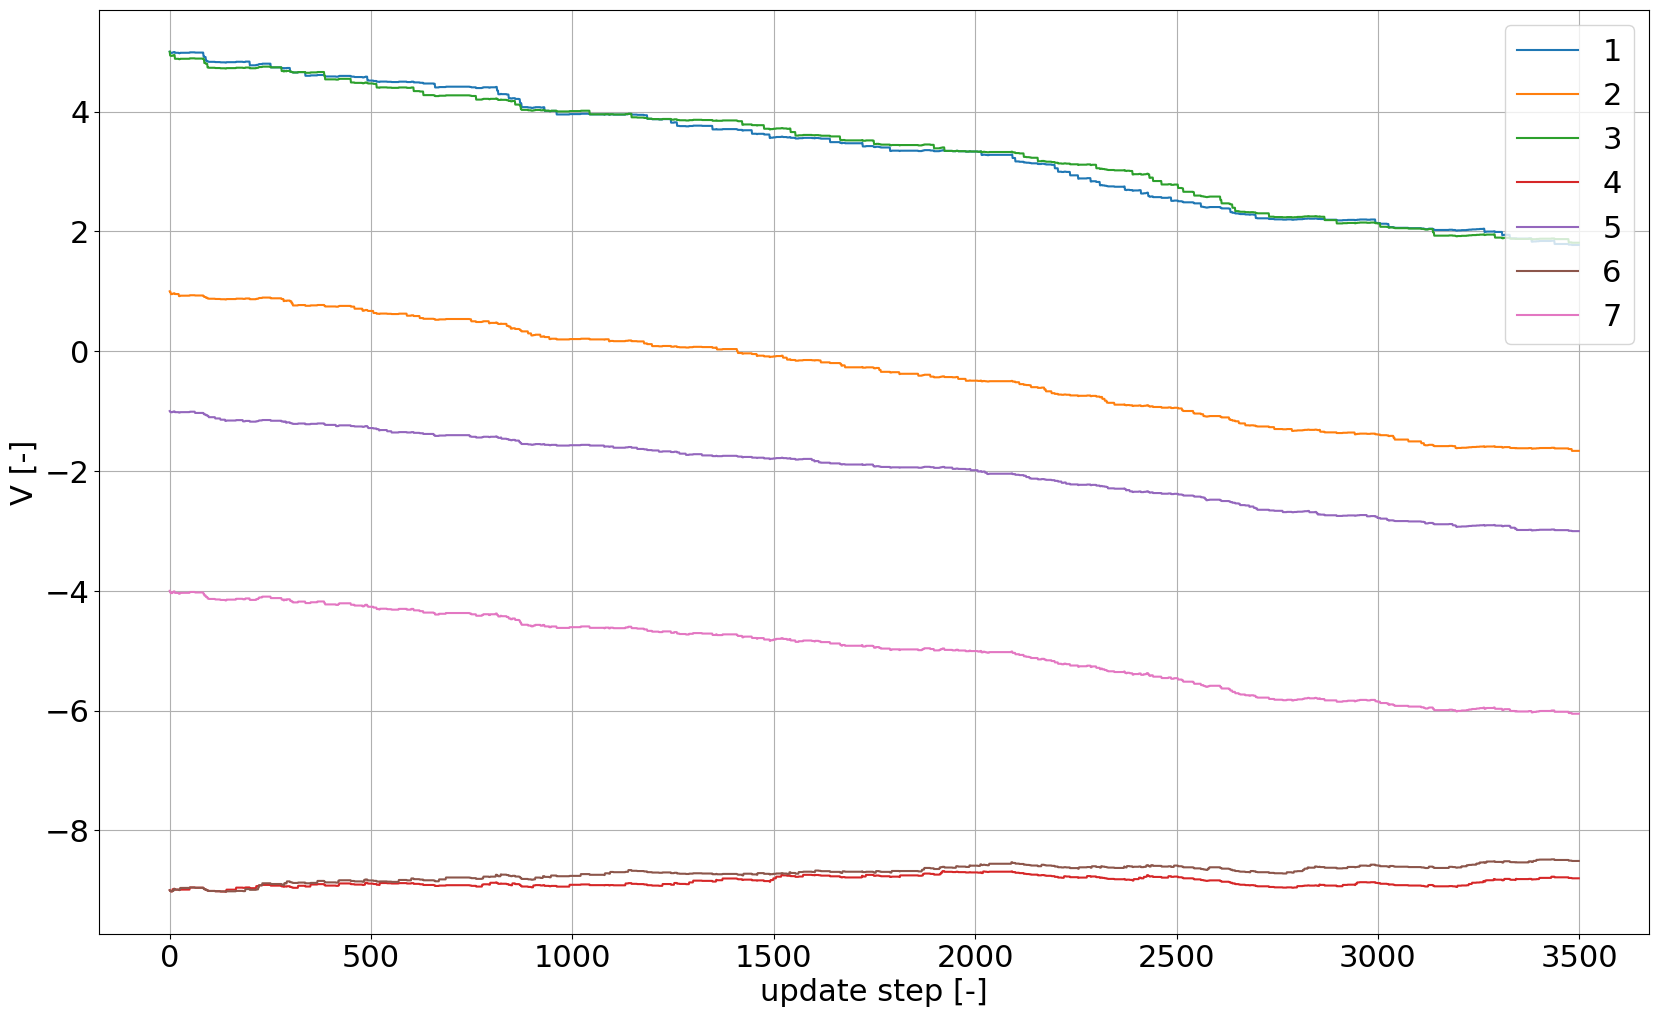

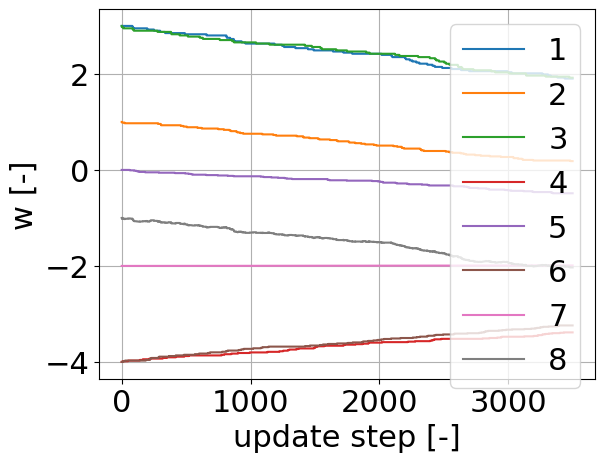

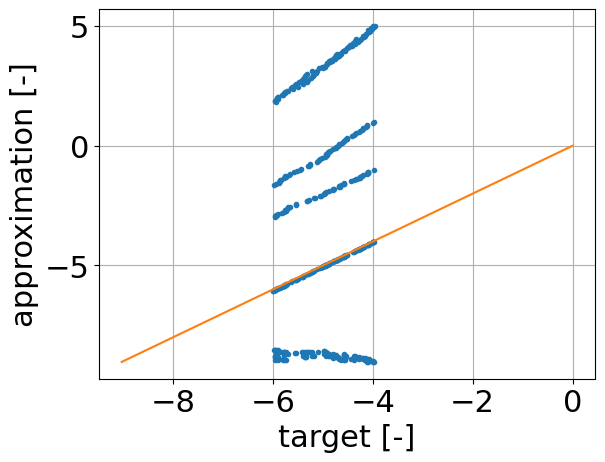

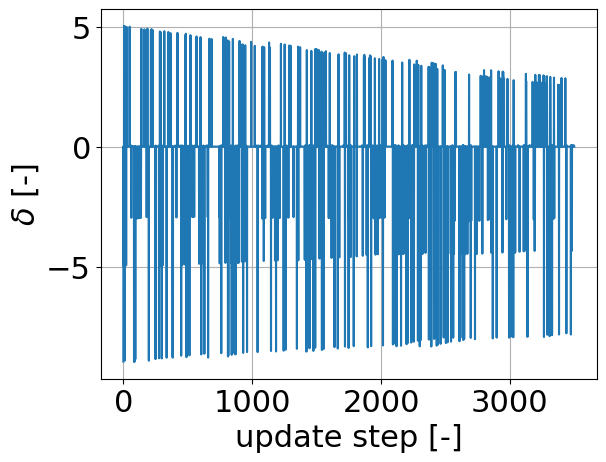

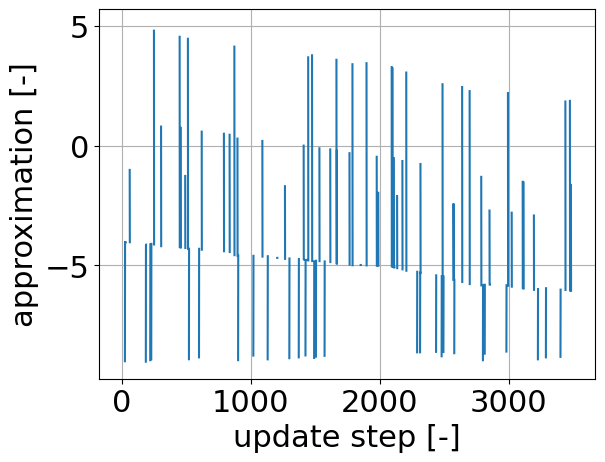

In [47]:
w, w_m, Dw8, target, approx, delta = SIGS[str(sim_index)]
plot_MDP(w, w_m, Dw8, target, approx, delta, PARS[str(sim_index)])

# Overall

## Parameter Table

In [74]:
print_table(PARS)

| sim | N_iterations | gamma | alpha | K  |                w0                 |            b            |  pi   | p8 |                     plot                      |                                                                                               X                                                                                               |
|-----|--------------|-------|-------|----|-----------------------------------|-------------------------|-------|----|-----------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|   1 |        19000 | 0.99  | 0.02  | 12 | [-3. -4. -2. -1. -4. -3. -2. -2.] | [0.14285714 0.85714286] | [1 0] |  1 | {'plot_1_1_line_in_target_approx_plot': True} |                                [[2 0 0 0 0 0 0 1] [0 2 0 0 0 0 0 1] [0 0 2 0 0 0 0 1] [0 0 0 2 0 0 0 1] [0 0 0 0 2 

## Performance Index Table

In [75]:
print_table(PERFORMANCE_INDEX)

| sim  | convergence_rate | correlation between update and approximation | approximation accuracy |
|------|------------------|----------------------------------------------|------------------------|
|    1 | No Convergence   | starts high, ends at 0                       | Low                    |
|    1 | Low              | High                                         | High                   |
|    2 | No Convergence   | High                                         | N/A                    |
|    3 | High             | 0                                            | Low                    |
|    4 | Low              | ?                                            | High                   |
|    5 | High             | High                                         | High                   |
|    6 | No Convergence   | High                                         | N/A                    |
|    7 | Medium           | 0                                            | Low                    |
